In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignorieren von FutureWarnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Business Understanding

Die folgenden Ziele sind ausgerichtet auf mittelfristigen Investoren mit einer Investitionsdauer von maximal 1–2 Jahren. 

1. **Identifikation von unterbewerteten Immobilien:** Das primäre Ziel des Regressionsmodells ist die präzise Vorhersage des fairen Verkaufspreises. Durch den Vergleich der Modellvorhersage mit den tatsächlichen Angebotspreisen sollen Häuser identifiziert werden, die signifikant unter dem Marktwert angeboten werden.

2. **Prädiktion der Bezirkszugehörigkeit:** Das primäre Ziel der Klassifikations- und Clusteranalysen ist die Bestimmung der Lage (Bezirk) einer Immobilie anhand ihrer physischen Merkmale. Durch die Untersuchung der Trennschärfe zwischen den Bezirken soll geprüft werden, ob spezifische Eigenschaftskombinationen eine eindeutige Vorhersage des Bezirks ermöglichen.

# 2. Data Exploration und Analyse

In [88]:
# Daten Einlesen
data_train = pd.read_csv('data_for_training.csv', sep=';')
data_test = pd.read_csv('data_for_test.csv', sep=';')

# Erste 10 Datensätze ausgeben
data_train.head(10)

A_Index Ausbaustufe  Baujahr Besonderheiten  EG_qm    Gesamtqual  \
0     1710     1 Ebene     1960            NaN    166  Durchschnitt   
1     1310     1 Ebene     1982            NaN    151  Durchschnitt   
2     2563     1 Ebene     1925            NaN     84      Schlecht   
3      373     1 Ebene     1968            NaN     95  Durchschnitt   
4     1464     1 Ebene     1979            NaN    133           Gut   
5      776  1,5 Ebenen     1951            NaN    114  Durchschnitt   
6     1874     1 Ebene     1954            NaN    124  Durchschnitt   
7       65    2 Ebenen     2003            NaN     70           Gut   
8     2289     1 Ebene     1999            NaN    102  Durchschnitt   
9     2390     1 Ebene     1977           Pool    200           Gut   

  Gesamtzustand  Grundstueck_qm   Kellerhoehe         Lage  QualInnenfarbe  \
0  Durchschnitt            1428  Durchschnitt  NeuBerlin_B               3   
1  Durchschnitt            2365           Gut  NeuBerlin_B               2   
2      Schlecht            1004      Schlecht  NeuBerlin_A               3   
3  Durchschnitt            1314  Durchschnitt  NeuBerlin_C               5   
4           Gut            1080           Gut  NeuBerlin_C               5   
5  Durchschnitt             962  Durchschnitt  NeuBerlin_C               2   
6  Durchschnitt             931      Schlecht  NeuBerlin_A               4   
7  Durchschnitt             217           Gut  NeuBerlin_A               1   
8  Durchschnitt            1660           Gut  NeuBerlin_B               2   
9      Schlecht            1440           Gut  NeuBerlin_C               2   

     Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  Z_Verkaufspreis  
0  Keine/Kaum      1960          2009             166           100088  
1      Mittel      1982          2006             151           145148  
2       Stark      1953          2011              84            48860  
3  Keine/Kaum      1968          2006              95            72349  
4  Keine/Kaum      2007          2007             133           138313  
5  Keine/Kaum      1953          2005             155            76230  
6  Keine/Kaum      1954          2008             124            84066  
7  Keine/Kaum      2003          2007             140           106907  
8      Mittel      1999          2007             102            93837  
9  Keine/Kaum      1977          2006             246           155623

Spalten: A_Index, Ausbaustufe, Baujahr, Besonderheiten, EG_qm, Gesamtqual, Gesamtzustand, Grundstueck_qm, Kellerhoehe, Lage, QualInnenfarbe, Steigung, Umgebaut, Verkaufsjahr, Wohnflaeche_qm, Z_Verkaufspreis

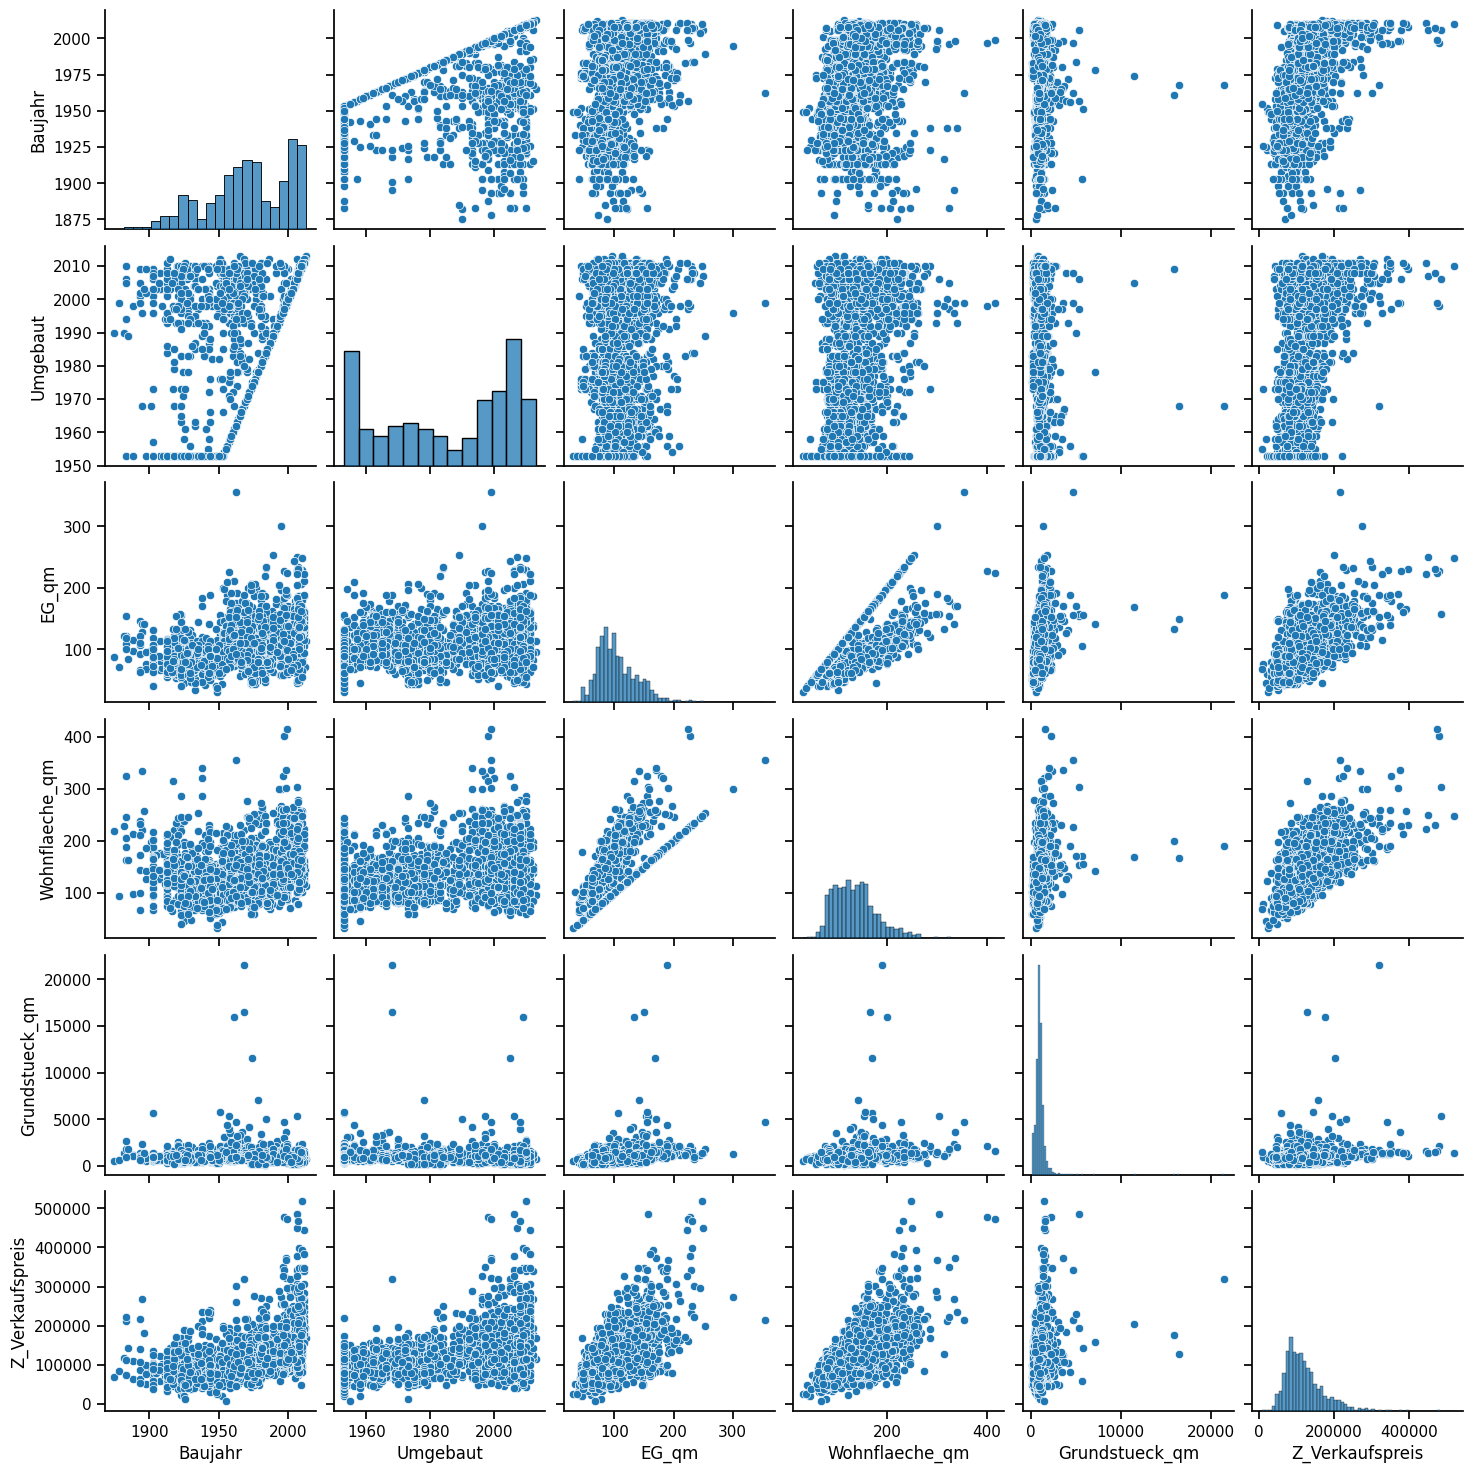

In [89]:
# Wähle gezielte metrische Spalten
land_vs_price = ['Baujahr', 'Umgebaut', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Z_Verkaufspreis']

# Scatterplot erstellen
scatterplot = sns.pairplot(data_train[land_vs_price])
scatterplot

**1. Ordinale und Nominale Einflüsse:**

Basierend auf den allgemeinen Scatterplots, welche die metrischen Zusammenhänge darstellen, lassen sich folgende Hypothesen und Handlungen ableiten:

- **Preistreiber:** Es ist eine positive Korrelation zwischen `Wohnflaeche_qm` und dem `Z_Verkaufspreis` erkennbar
    - Die Beziehung wirkt weitgehend linear, zeigt aber bei sehr großen Flächen eine zunehmende Varianz
    - `EG_qm` scheint aus denselben gründen positiv mit `Z_Verkaufspreis` korreliert zu sein
- **Ausreißer:** Das Feature `Grundstueck_qm` zeigt massive Ausreißer (einzelne Punkte weit rechts von 5.000qm, jedoch Großteil der Daten < 5.000qm). Diese Ausreißer stauchen die Skala und erschweren das Lernen für lineare Modelle
    - Diese Ausreißer sind zu entfernen, oder zumindest auch zuvor ohne diese zu betrachten, um daraufhin eine Entscheidung über das Vorgehen treffen zu können
- **Alter und Preis:** Neuere Häuser (`Baujahr`) scheinen eher höhere Preise zu haben, die Streuung ist jedoch groß. Vermutbar ist, dass das Baujahr allein nicht reicht und der allgemeine Zustand des Hauses (`Gesamtqual` und `Gesamtzustand`), sowie ob das Gebäude renoviert wurde (`Umgebaut`) ebenfalls eine Rolle spielt
 - **Umbau:** Das Merkmal `Umgebaut` scheint sich ähnlichen Einfluss auf den Verkaufspreis wie das Merkmal `Baujahr` zu haben. Da Häuser, welche bisher nicht umgebaut wurden, hier ihr Baujahr eingetragen haben erscheint dies auch logisch. Häuser, welche seit langer Zeit nicht umgebaut wurden scheinen einen eher geringeren Verkaufspreis zu haben.

#### Besonderheiten in den Plots
Einige der Plots zeigen unnatürliche Cutoffs in den Datensätzen. Bei genauerer Betrachtung lassen sich diese jedoch erklären.

Die Trennlinie von `Baujahr` mit `Umgebaut` lässt sich dadurch erklären, dass ein Haus erst umgebaut werden kann, nachdem es gebaut wurde. Ferner ist die Trennlinie bei `EG_qm` mit `Wohnfläche_qm` auch logisch. Die Wohnfläche eines Hauses kann in keinem Fall kleiner sein als die Fläche des Erdgeschosses.

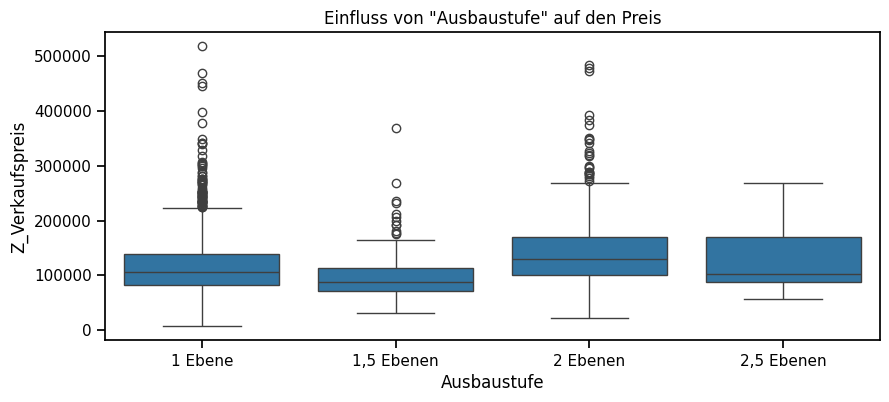

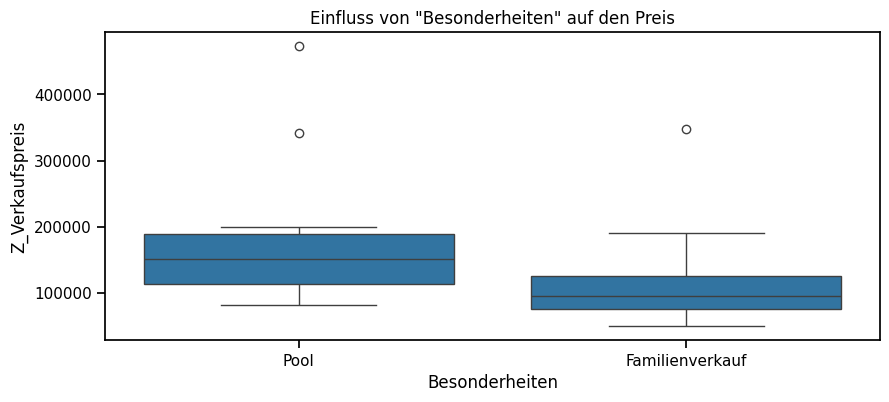

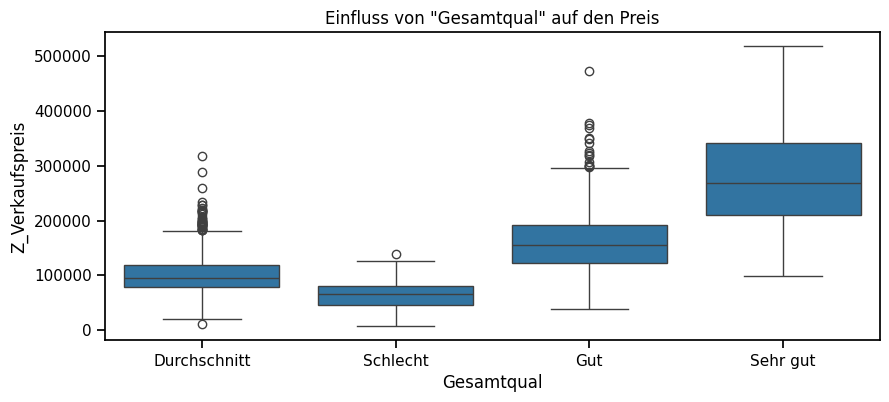

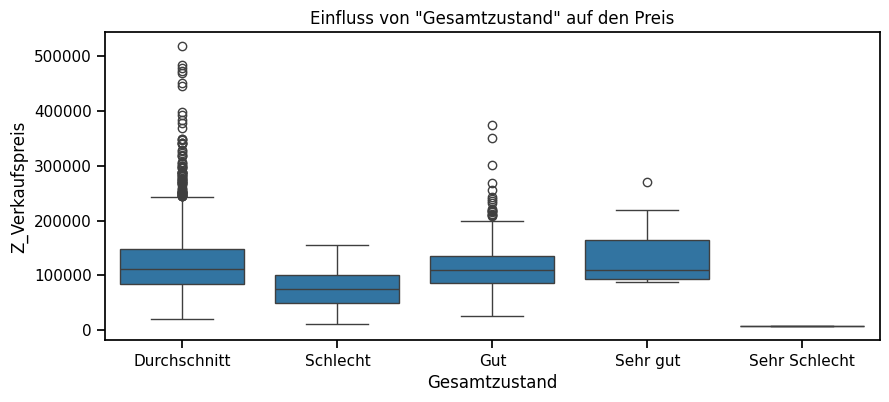

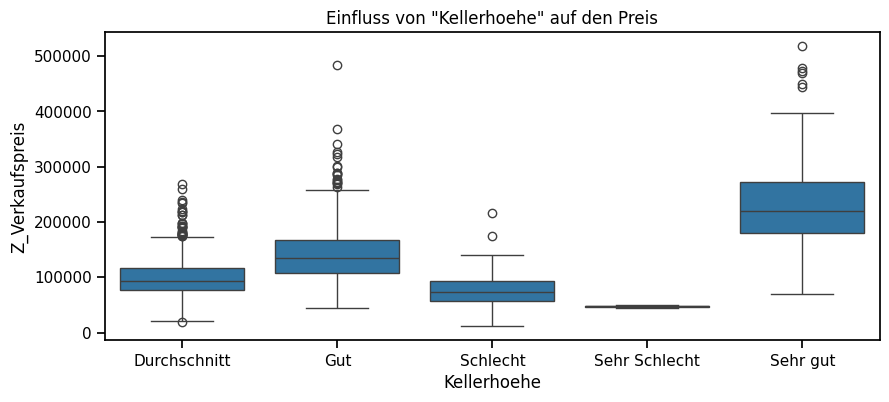

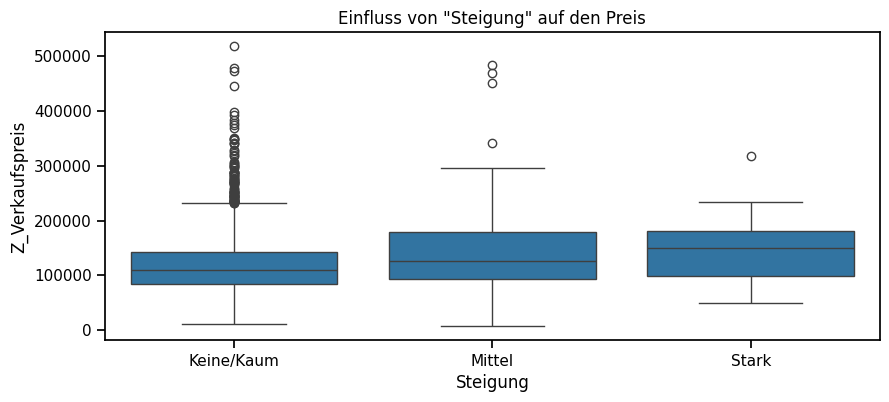

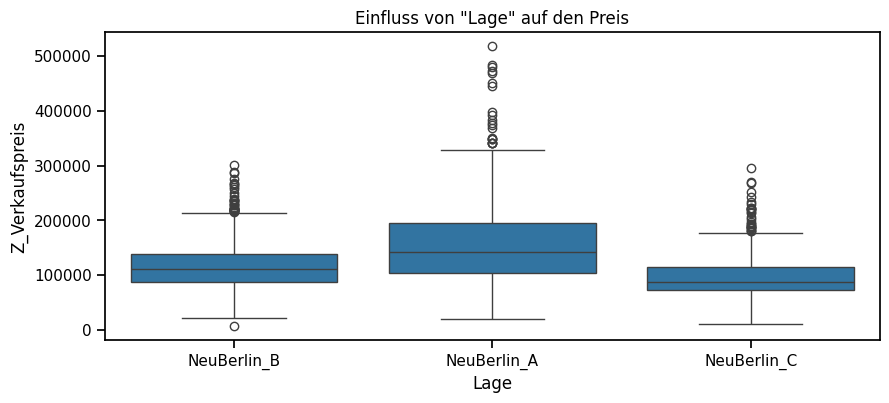

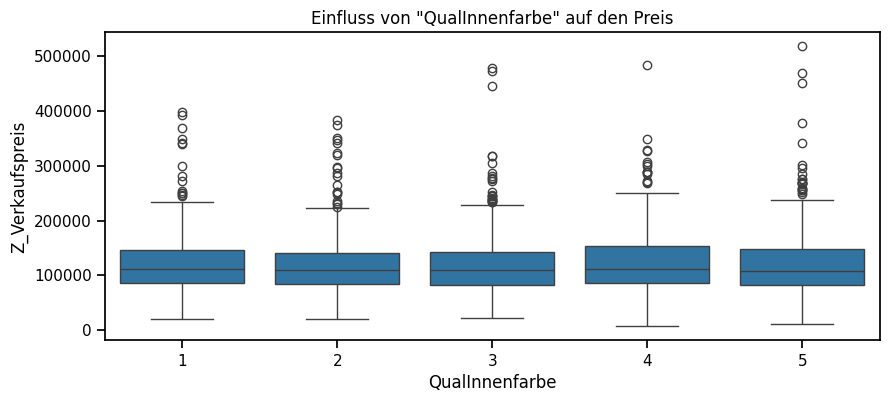

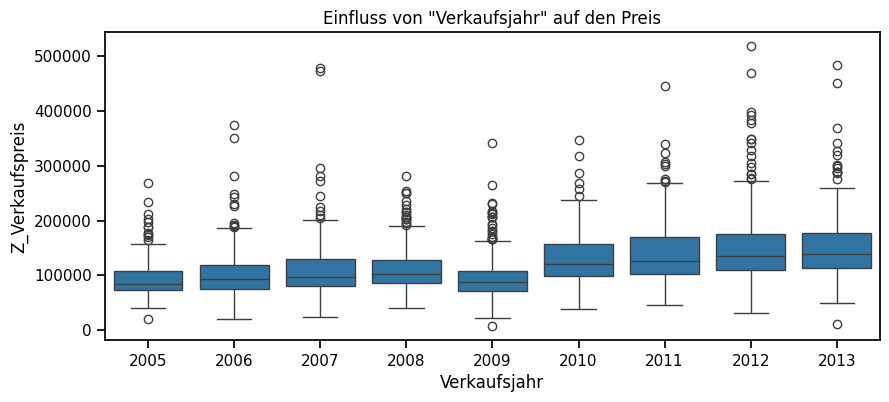

In [90]:
# Wähle ordinale und nominale Spalten
categorical = ['Ausbaustufe', 'Besonderheiten', 'Gesamtqual', 'Gesamtzustand', 'Kellerhoehe', 'Steigung', 'Lage', 'QualInnenfarbe', 'Verkaufsjahr']

# Für jede Kategorie einen Plot machen
for column in categorical:
    plt.figure(figsize=(10, 4))
    # Sortierung hilft beim Lesen (optional)
    sns.boxplot(x=column, y='Z_Verkaufspreis', data=data_train)
    plt.title(f'Einfluss von "{column}" auf den Preis')
    plt.show()

**2. Ordinale und Nominale Einflüsse:**
- **Qualität:** Der Boxplot zu `Gesamtqual` zeigt, dass die Gesamtqualität des Hauses einen Unterschied macht. Je besser die Qualität, umso höher ist der Median-Preis. Die Boxen überlappen sich zudem kaum, was bedeutet, dass dieses Merkmal eine hohe Trennschärfe besitzt
- **Trend und Plausibilität:** Grundsätzlich ist der erwartete Trend erkennbar: Je besser der Zustand (von "Schlecht" zu "Sehr gut"), desto höher tendenziell der Median des Z_Verkaufspreis
    - Besonders die Kategorie "Sehr gut" hebt sich in beiden Merkmalen deutlich durch ein höheres Preisniveau und eine größere Varianz nach oben ab
    - Problem der Unterrepräsentation: Die Kategorie "Sehr Schlecht" zeigt in beiden Plots fast keine Varianz. Dies deutet stark darauf hin, dass hier nur extrem wenige Beobachtungen vorliegen
    - Diese spärliche Besetzung ist für ein Klassifikations-/Regressionsmodell problematisch, da es zu Overfitting auf diese wenigen Ausreißer führen kann
    - Um das Modell zu stabilisieren, sollten die Kategorie "Sehr Schlecht" mit der Kategorie "Schlecht" zusammengefasst werden
- **Steigung:** Häuser mit "Starker" `Steigung` haben einen etwas höheren Median als flache Grundstücke. Dies könnte mit einer besseren Aussicht (Hanglage) korrelieren
-  **Lage:** Geringer Einfluss
- **Besonderheiten:** Der Plot zu `Besonderheiten` zeigt nur "Pool" und "Familienverkauf". Ein Blick in die Rohdaten zeigt viele `NaN`-Werte
    - *Interpretation:* `NaN` bedeutet wahrscheinlich, dass ein Haus keine Besonderheit hat
    - Während der Data Preparaion sollten diese Zeilen nicht gelöscht werden, stattdessen sollten die `NaN`-Werte durch eine Kategorie wie "Standard" ersetzt werden
    - Ein Pool scheint den Preis signifikant zu heben, erkennbar durch den höheren Median
- **Kellerhöhe:** Es ist eine positive Tendenz erkennbar. Kategorien wie "Sehr gut" korrelieren mit deutlich höheren Verkaufspreisen als "Durchschnitt" oder "Schlecht"
    - Auffällig ist die hohe Varianz bei "Sehr gut": Eine sehr gute Kellerhöhe ermöglicht hohe Preise, garantiert sie aber nicht (die Box ist sehr lang gestreckt)
    - Die Kategorie "Sehr Schlecht" wird im Plot lediglich als flache Linie dargestellt. Dies ist ein Indikator für eine extrem geringe Fallzahl. Da diese Kategorie statistisch nicht signifikant ist, sollte sie mit der Kategorie "Schlecht" zusammengefasst werden, ähnlich 
- **Verkaufsjahr:** Geringe Tendenz, dass später verkaufte Häuser auch teurer verkauft wurden
    - *Interpretation*: Umso später ein Haus verkauft wird, umso neuer und somit moderner wird es vermutlich sein
    - Häuser im Jahr 2009 scheinen eine Ausnahme darzustellen, da hier der Verkaufspreis im Median sogar geringer ist als im Vorjahr
    - *Handlung:* Ob dies tatsächlich der Fall ist, beispielsweise durch die Finanzkrise zu dieser Zeit bedingt, ist der Preis pro Quadratmeter zu begutachten, um auszuschließen, dass 2009 nicht durch Zufall nur günstigere Häuser verkauft wurden (somit Selection Bias vermeiden)
- **Ohne/Wenig Einfluss:**
    - Das Merkmal `Ausbaustufe` scheint nicht logisch mit dem Verkaufspreis korreliert zu sein, die Boxplots zeigen, dass mehr Ebenen nicht direkt einen höheren Verkaufspreis zur folge haben
    - Das Merkmal `QualInnenfarbe` hat den Boxplots zu urteilen keinen Einfluss auf den Verkaufspreis

## 2.1 Betrachtung der Daten ohne Außreiser in `Grundstueck_qm`

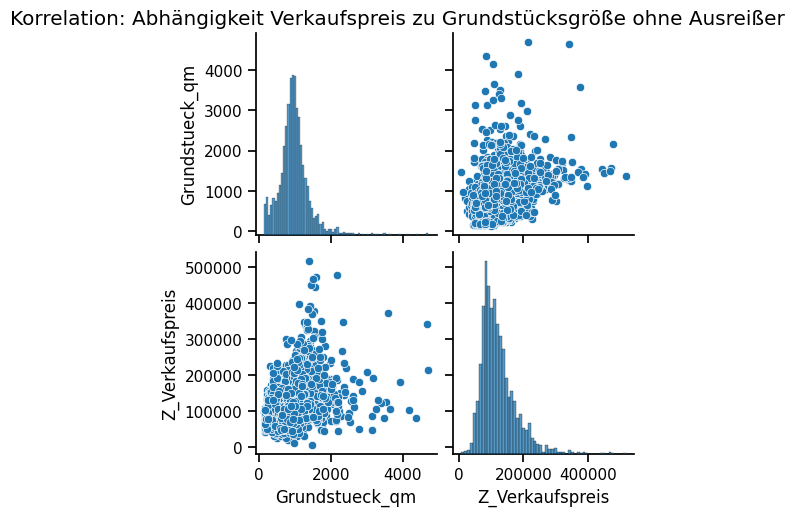

In [91]:
land_vs_price = ['Grundstueck_qm', 'Z_Verkaufspreis']

# Filtering: Wir behalten nur Einträge unter 5.000 qm
data_train_filtered = data_train[data_train['Grundstueck_qm'] < 5000].copy()

scatterplot = sns.pairplot(data_train_filtered[land_vs_price])
scatterplot.figure.suptitle(
    'Korrelation: Abhängigkeit Verkaufspreis zu Grundstücksgröße ohne Ausreißer',
    y=1.02  # Schiebt den Titel etwas nach oben, damit nichts überlappt
)
plt.show()

**Auswertung:**
Wie vermutet, wird nun eine positive Korrelation sichtbar. Tendenziell führen größere Grundstücke zu höheren Verkaufspreisen. Trotz des erkennbaren Trends ist die Streuung der Datenpunkte sehr hoch. Dies deutet darauf hin, dass die Grundstücksgröße zwar einen Einfluss auf den Basispreis hat, aber alleine als Merkmal nicht aussagekräftig genug zur Vorhersage des Verkaufspreises ist. In der Phase der Data Preparation sind diese Außreiser tatsächlich zu filtern.

## 2.2 Analyse des Preisabfalls im Verkaufsjahr 2009

Zuvor betrachten wir, ob die in 2009 verkauften Häuser nicht zufällig eine geringere Wohnfläche hatten, im Vergleich zu den restlichen Jahren.

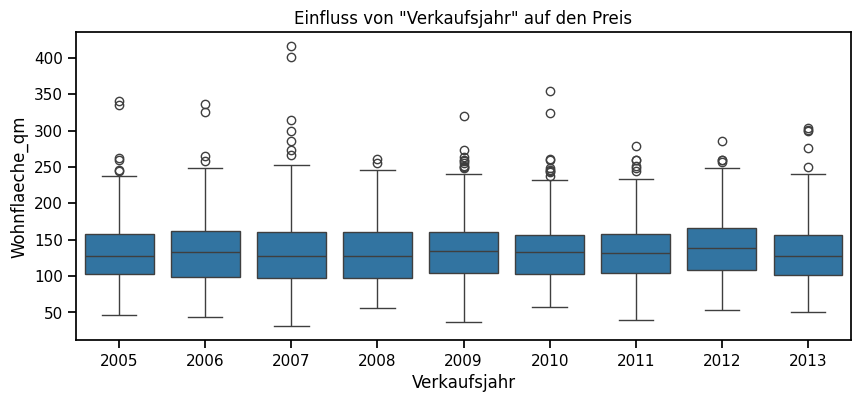

In [92]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Wohnflaeche_qm', data=data_train)
plt.title(f'Einfluss von "Verkaufsjahr" auf den Preis')
plt.show()

Nun betrachten wir den Quadratmeterpreis in den verschiedenen Verkaufsjahren.

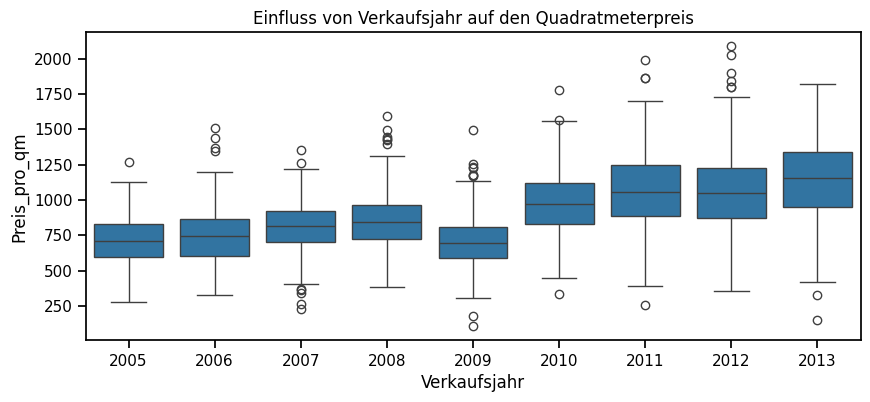

In [93]:
data_train['Preis_pro_qm'] = data_train['Z_Verkaufspreis'] / data_train['Wohnflaeche_qm']

plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Preis_pro_qm', data=data_train)
plt.title('Einfluss von Verkaufsjahr auf den Quadratmeterpreis')
plt.show()

**Auswertung:**
Der Preisrückgang im Jahr 2009 scheint tatsächlich durch eine Finanzkrise bedingt zu sein, da der Quadratmeterpreis sinkt, während die verkaufte Wohnfläche konstant bleibt.

## 2.3 Fehlende Werte bei `Besonderheiten`

Die `NaN`-Werte aus dem Merkmal Besonderheiten werden der Kategorie "Standard" zugeordnet um sie somit auch analysieren zu können.

In [94]:
# NaN Werte durch 'Standard' ersetzen
data_train['Besonderheiten'] = data_train['Besonderheiten'].fillna('Standard')

# Check
print(data_train['Besonderheiten'].value_counts())

Besonderheiten
Standard           2331
Familienverkauf      43
Pool                 10
Name: count, dtype: int64


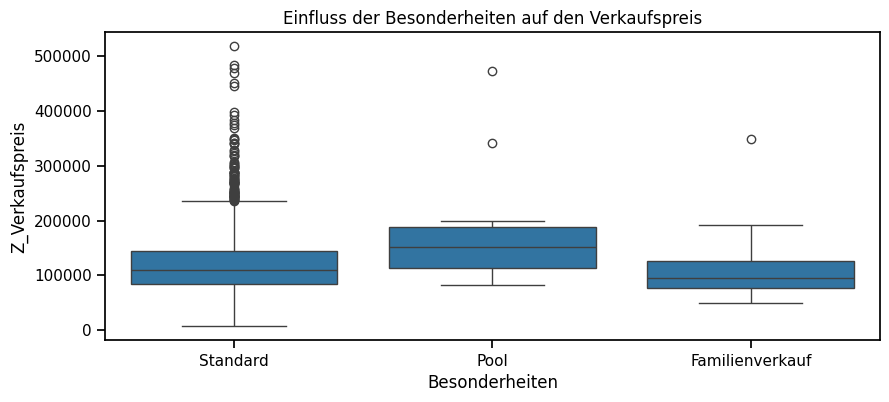

In [95]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Besonderheiten', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Besonderheiten auf den Verkaufspreis')
plt.show()

## 2.4 Erkenntnis nach Binning 

Folgende Zelle wurde als Teil der Data Preparation ausgeführt.

In [96]:
# Definition des Mappings: "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Kellerhoehe'] = data_train['Kellerhoehe'].replace(cleanup_map)
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].replace(cleanup_map)

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' nan]


Hier zeigt sich, dass Häuser ohne Keller für das Merkmal `Kellerhoehe` den Wert `NaN` eingetragen haben, somit erschienen diese Häuser bisher nicht in dem Boxplot, welcher den Zusammenhang zwischen Kellerhöhe und Verkaufspreis untersuchte. So wie zuvor für das Merkmal `Besonderheiten` geschehen sind nun auch hier die `NaN`-Werte einer Kategorie zuzuordnen.

In [97]:
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].fillna('Kein Keller')
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].fillna('Kein Keller')

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' 'Kein Keller']


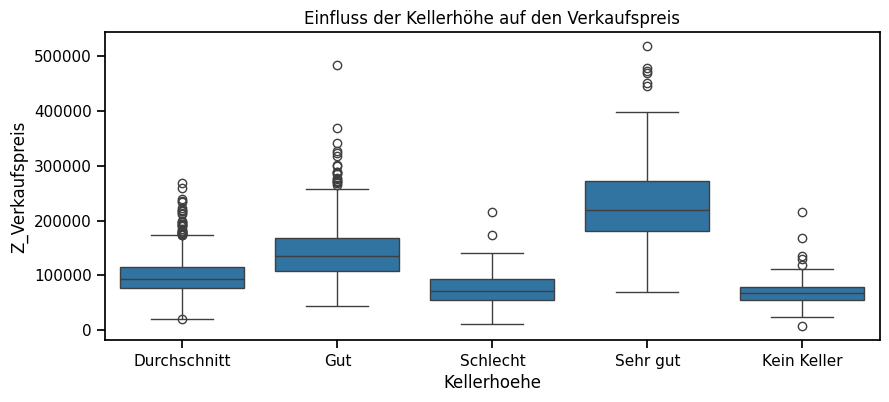

In [98]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Kellerhoehe', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Kellerhöhe auf den Verkaufspreis')
plt.show()

**Auswertung:** Der Plot zeigt nun, dass Häuser ohne Keller einen geringeren Verkaufspreis haben zu scheinen, oder zumindest ähnlich zu Häusern mit schlechter Kellerhöhe. Diese Auswertung entspricht der Intuition.

## 2.5 Analyse der numerischen Merkmale für Feature Scaling
Um eine fundierte Entscheidung über das Feature Scaling treffen zu können, wurden die Schiefe (Skewness) und die deskriptiven Statistiken der numerischen Merkmale analysiert.

In [99]:
print('Skewness:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].skew())
print('Description:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].describe())

Skewness:
Baujahr           -0.535609
EG_qm              1.072032
Wohnflaeche_qm     1.018008
Grundstueck_qm    13.554205
dtype: float64
Description:
           Baujahr        EG_qm  Wohnflaeche_qm  Grundstueck_qm
count  2384.000000  2384.000000     2384.000000     2384.000000
mean   1971.017198   104.883389      136.684144     1014.106544
std      29.620103    34.216459       45.470373      820.408957
min    1875.000000    31.000000       31.000000      132.000000
25%    1953.000000    80.000000      101.000000      746.750000
50%    1973.000000    98.000000      132.000000      942.000000
75%    1999.000000   124.000000      160.000000     1149.250000
max    2013.000000   355.000000      416.000000    21530.000000


**Auswertung:** Da die Wertebereiche der Merkmale stark variieren (z.B. Baujahr ~2000 vs. Wohnfläche ~100), ist eine Skalierung für viele Machine-Learning-Algorithmen (wie Lineare Regression) zwingend erforderlich. Da die Merkmale `EG_qm`, `Wohnflaeche_qm` und `Grundstueck_qm` eine deutliche Rechtsschiefe aufweisen, kann eine zusätzliche Log-Transformation vor dem Scaling bessere Ergebnisse liefern.

# 3. Data Preparation

## 3. Filtern der Außreiser von `Grundstueck_qm`

Da sich das Filtern der Außreißer in Kapitel 2.1 als sinnvoll erwiesen hat, wenden wir den Filter nun auf unsere tatsächlichen Daten an.

In [100]:
# Speichern der ursprünglichen Anzahl, um zu sehen, wie viele Datenpunkte entfernt werden
rows_before = data_train.shape[0]

# Filtern
data_train = data_train[data_train['Grundstueck_qm'] < 5000]

rows_after = data_train.shape[0]

print(f"Gelöschte Ausreißer: {rows_before - rows_after}")

Gelöschte Ausreißer: 10


## 3.1 Binning von Kategorien mit wenigen Datenpunkten

In [101]:
# "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Gesamtzustand'] = data_train['Gesamtzustand'].replace(cleanup_map)
data_test['Gesamtzustand'] = data_test['Gesamtzustand'].replace(cleanup_map)

print("Werte für Gesamtzustand:", data_train['Gesamtzustand'].unique())

Werte für Gesamtzustand: ['Durchschnitt' 'Schlecht' 'Gut' 'Sehr gut']


Für die Kellerhöhe wurde dieser Schritt bereits in Kaptiel 2.4 erledigt.

## 3.2 Entfernen irrelevanter Merkmale

Da die Merkmale A-Index sowie die Qualität der Innenfarbe keinen logischen Zusammenhang oder Mehrwert in der Analyse zeigten, werden diese entfernt.

Obwohl das Merkmal Ausbaustufe ebenfalls keinen linearen Zusammenhang gezeigt hat, darf dieses nicht gelöscht werden, da die Boxplots signifikante Unterschiede zwischen spezifischen Kategorien offenbarten. Diese nicht-linearen Informationen sind für baumbasierte Modelle wertvoll. Zudem wird dieses Merkmal für die Klassifikationsaufgabe zwingend benötigt.

In [102]:
drop_cols = ['QualInnenfarbe', 'A_Index']

data_train = data_train.drop(drop_cols, axis=1, errors='ignore')
data_test = data_test.drop(drop_cols, axis=1, errors='ignore')

## 3.3 Feature-Engineering "Preis pro Quadratmeter"

Um die Datenqualität zu überprüfen, wurde temporär das Merkmal `Preis_pro_qm` abgeleitet (Verkaufspreis / Wohnfläche). Da dieses Merkmal den Zielwert `Z_Verkaufspreis` direkt beinhaltet, wurde es ausschließlich für die Analyse und Bereinigung verwendet und nicht als Feature in das Training der Vorhersagemodelle aufgenommen, um Data Leakage zu vermeiden. Somit wird dieses Feature wieder entfernt.

In [103]:
data_train = data_train.drop('Preis_pro_qm', axis=1, errors='ignore')

print("Spalte 'Preis_pro_qm' erfolgreich entfernt." if 'Preis_pro_qm' not in data_train.columns else "Fehler beim Entfernen.")

Spalte 'Preis_pro_qm' erfolgreich entfernt.


## 3.4 Encoding Kategorischer Merkmale

Um die kategorischen Merkmale für die Modellierung vorzubereiten, werden diese mittels One-Hot-Encoding für nominale Merkmale und Label-Encoding für ordinale Merkmale in numerische Merkmale umgewandelt. Dies ermöglicht es den Modellen, die kategorialen Informationen effektiv zu nutzen.

In [104]:
# Definition der Mappings für Ordinale Merkmale
quality_map = {'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}
steigung_map = {'Keine/Kaum': 1, 'Mittel': 2, 'Stark': 3}
keller_map = {'Kein Keller': 0, 'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}
stockwerke_map = {'1 Ebene': 1.0, '1,5 Ebenen': 1.5, '2 Ebenen': 2.0, '2,5 Ebenen': 2.5}

# Anwenden der Ordinalen Encodings
data_train['Gesamtqual'] = data_train['Gesamtqual'].map(quality_map)
data_train['Gesamtzustand'] = data_train['Gesamtzustand'].map(quality_map)
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].map(keller_map)
data_train['Steigung'] = data_train['Steigung'].map(steigung_map)
data_train['Ausbaustufe'] = data_train['Ausbaustufe'].map(stockwerke_map)

data_test['Gesamtqual'] = data_test['Gesamtqual'].map(quality_map)
data_test['Gesamtzustand'] = data_test['Gesamtzustand'].map(quality_map)
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].map(keller_map)
data_test['Steigung'] = data_test['Steigung'].map(steigung_map)
data_test['Ausbaustufe'] = data_test['Ausbaustufe'].map(stockwerke_map)

# Nominal Encoding (One-Hot Encoding) für 'Besonderheiten' und 'Lage'
# drop_first=True um Multikollinearität zu vermeiden (Dummy Trap)
data_train = pd.get_dummies(data_train, columns=['Besonderheiten', 'Lage'], drop_first=False)
data_test = pd.get_dummies(data_test, columns=['Besonderheiten', 'Lage'], drop_first=False)

data_test = data_test.reindex(columns=data_train.columns, fill_value=False)
data_test = data_test.drop('Z_Verkaufspreis', axis=1, errors='ignore')

# Überprüfung der Datentypen und ersten Zeilen
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 0 to 2383
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Ausbaustufe                     2374 non-null   float64
 1   Baujahr                         2374 non-null   int64  
 2   EG_qm                           2374 non-null   int64  
 3   Gesamtqual                      2374 non-null   int64  
 4   Gesamtzustand                   2374 non-null   int64  
 5   Grundstueck_qm                  2374 non-null   int64  
 6   Kellerhoehe                     2374 non-null   int64  
 7   Steigung                        2374 non-null   int64  
 8   Umgebaut                        2374 non-null   int64  
 9   Verkaufsjahr                    2374 non-null   int64  
 10  Wohnflaeche_qm                  2374 non-null   int64  
 11  Z_Verkaufspreis                 2374 non-null   int64  
 12  Besonderheiten_Familienverkauf  2374 no

Ausbaustufe  Baujahr  EG_qm  Gesamtqual  Gesamtzustand  Grundstueck_qm  \
0          1.0     1960    166           2              2            1428   
1          1.0     1982    151           2              2            2365   
2          1.0     1925     84           1              1            1004   
3          1.0     1968     95           2              2            1314   
4          1.0     1979    133           3              3            1080   

   Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  \
0            2         1      1960          2009             166   
1            3         2      1982          2006             151   
2            1         3      1953          2011              84   
3            2         1      1968          2006              95   
4            3         1      2007          2007             133   

   Z_Verkaufspreis  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
0           100088                           False                False   
1           145148                           False                False   
2            48860                           False                False   
3            72349                           False                False   
4           138313                           False                False   

   Besonderheiten_Standard  Lage_NeuBerlin_A  Lage_NeuBerlin_B  \
0                     True             False              True   
1                     True             False              True   
2                     True              True             False   
3                     True             False             False   
4                     True             False             False   

   Lage_NeuBerlin_C  
0             False  
1             False  
2             False  
3              True  
4              True

In [105]:
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Ausbaustufe                     265 non-null    float64
 1   Baujahr                         265 non-null    int64  
 2   EG_qm                           265 non-null    int64  
 3   Gesamtqual                      265 non-null    int64  
 4   Gesamtzustand                   265 non-null    int64  
 5   Grundstueck_qm                  265 non-null    int64  
 6   Kellerhoehe                     265 non-null    int64  
 7   Steigung                        265 non-null    int64  
 8   Umgebaut                        265 non-null    int64  
 9   Verkaufsjahr                    265 non-null    int64  
 10  Wohnflaeche_qm                  265 non-null    int64  
 11  Besonderheiten_Familienverkauf  265 non-null    bool   
 12  Besonderheiten_Pool             265 

## 3.5 Feature Scaling
Die numerischen Merkmale weisen unterschiedliche Wertebereiche und Verteilungen auf. Um die Leistung der Machine-Learning-Modelle zu verbessern, wird ein Feature Scaling durchgeführt. Hierbei wird der StandardScaler verwendet, der die Merkmale so transformiert, dass sie einen Mittelwert von 0 und eine Standardabweichung von 1 aufweisen.

In [106]:
from sklearn.preprocessing import StandardScaler

# Numerische Spalten definieren
numerical_cols = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Verkaufsjahr', 'Umgebaut']

# Scaler initialisieren und anwenden
scaler = StandardScaler()
X_log = np.log1p(data_train[numerical_cols])
data_train[numerical_cols] = scaler.fit_transform(X_log)

X_log_test = np.log1p(data_test[numerical_cols])
data_test[numerical_cols] = scaler.transform(X_log_test)

# Ergebnis überprüfen
print("Mittelwerte nach Scaling (sollten ~0 sein):\n", data_train[numerical_cols].mean())
print("\nStd-Abweichung nach Scaling (sollte ~1 sein):\n", data_train[numerical_cols].std())
data_train.head()

Mittelwerte nach Scaling (sollten ~0 sein):
 Baujahr          -1.512971e-14
EG_qm             2.044232e-15
Wohnflaeche_qm    1.744930e-15
Grundstueck_qm    3.292321e-17
Verkaufsjahr      1.687707e-13
Umgebaut         -4.439283e-14
dtype: float64

Std-Abweichung nach Scaling (sollte ~1 sein):
 Baujahr           1.000211
EG_qm             1.000211
Wohnflaeche_qm    1.000211
Grundstueck_qm    1.000211
Verkaufsjahr      1.000211
Umgebaut          1.000211
dtype: float64


Ausbaustufe   Baujahr     EG_qm  Gesamtqual  Gesamtzustand  Grundstueck_qm  \
0          1.0 -0.364652  1.620925           2              2        0.990605   
1          1.0  0.374775  1.319800           2              2        2.020135   
2          1.0 -1.558284 -0.539905           1              1        0.271916   
3          1.0 -0.094814 -0.150523           2              2        0.820853   
4          1.0  0.274428  0.916519           3              3        0.420761   

   Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  \
0            2         1 -1.224508     -0.049321        0.763730   
1            3         2 -0.148821     -1.213078        0.471898   
2            1         3 -1.569304      0.725553       -1.330411   
3            2         1 -0.831959     -1.213078       -0.953046   
4            3         1  1.059159     -0.824966        0.081064   

   Z_Verkaufspreis  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
0           100088                           False                False   
1           145148                           False                False   
2            48860                           False                False   
3            72349                           False                False   
4           138313                           False                False   

   Besonderheiten_Standard  Lage_NeuBerlin_A  Lage_NeuBerlin_B  \
0                     True             False              True   
1                     True             False              True   
2                     True              True             False   
3                     True             False             False   
4                     True             False             False   

   Lage_NeuBerlin_C  
0             False  
1             False  
2             False  
3              True  
4              True

# 4. Modeling - Regression mit Inferenz

In diesem Abschnitt werden verschiedene Regressionsmodelle trainiert und evaluiert, um den Verkaufspreis von Immobilien vorherzusagen.

**Verfahren**: Es werden lineare Regression, Entscheidungsbaumregression und Random Forest Regression verwendet. 

**Evaluierung**: Die Modelle werden anhand der Metriken wie dem Mean Absolute Error (MAE) und dem R²-Wert bewertet, um ihre Vorhersagegenauigkeit zu vergleichen.

**Feature Importance**: Zusätzlich wird die Bedeutung der einzelnen Merkmale analysiert, um Einblicke in die wichtigsten Einflussfaktoren auf den Verkaufspreis zu gewinnen.

## 4.1 Splitting der Daten in Trainings- und Validierungsset
Hier werden die Daten in ein Trainings- und ein Validierungsset aufgeteilt, um die Modelle zu trainieren und ihre Leistung zu bewerten. Außerdem wird ein Testset zurückgehalten, um die finale Modellbewertung durchzuführen.

In [107]:
from sklearn.model_selection import train_test_split

TRAIN_VALID_RATIO = 0.8
x_train, x_valid = train_test_split(data_train, train_size=TRAIN_VALID_RATIO, random_state=42)

y_train = x_train['Z_Verkaufspreis']
y_valid = x_valid['Z_Verkaufspreis']

x_train = x_train.drop('Z_Verkaufspreis', axis=1)
x_valid = x_valid.drop('Z_Verkaufspreis', axis=1)

x_train.head()

Ausbaustufe   Baujahr     EG_qm  Gesamtqual  Gesamtzustand  \
1384          1.0 -0.297090  0.314002           2              2   
2102          1.0 -0.027526 -0.117366           1              2   
287           1.0  0.774649 -0.321666           2              2   
672           1.0  1.238139  1.842952           3              2   
408           2.0  0.973684  0.844072           3              2   

      Grundstueck_qm  Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  \
1384        0.667747            2         1 -1.126221      1.499657   
2102        0.563016            2         1 -0.734071      1.112701   
287         0.418872            3         1  0.481217     -0.824966   
672         0.976266            4         1  1.155147     -0.437047   
408         0.154851            3         1  0.770621     -1.601384   

      Wohnflaeche_qm  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
1384       -0.502857                           False                False   
2102       -0.920912                           False                False   
287        -1.118907                           False                False   
672         0.978905                           False                False   
408         1.660430                           False                False   

      Besonderheiten_Standard  Lage_NeuBerlin_A  Lage_NeuBerlin_B  \
1384                     True             False              True   
2102                     True             False              True   
287                      True             False              True   
672                      True              True             False   
408                      True              True             False   

      Lage_NeuBerlin_C  
1384             False  
2102             False  
287              False  
672              False  
408              False

In [108]:
y_train.head()

1384    127800
2102    138396
287      59322
672     253830
408     196505
Name: Z_Verkaufspreis, dtype: int64

## 4.2 Modelltraining
Hier werden die verschiedenen Regressionsmodelle trainiert und ihre Leistung auf dem Validierungsset evaluiert.

### 4.2.1 Lineare Regression
Hier wird eine lineare Regression trainiert und evaluiert.

Mean Absolute Error (MAE): 19253.719570384143
R² Score: 0.7518415198144424


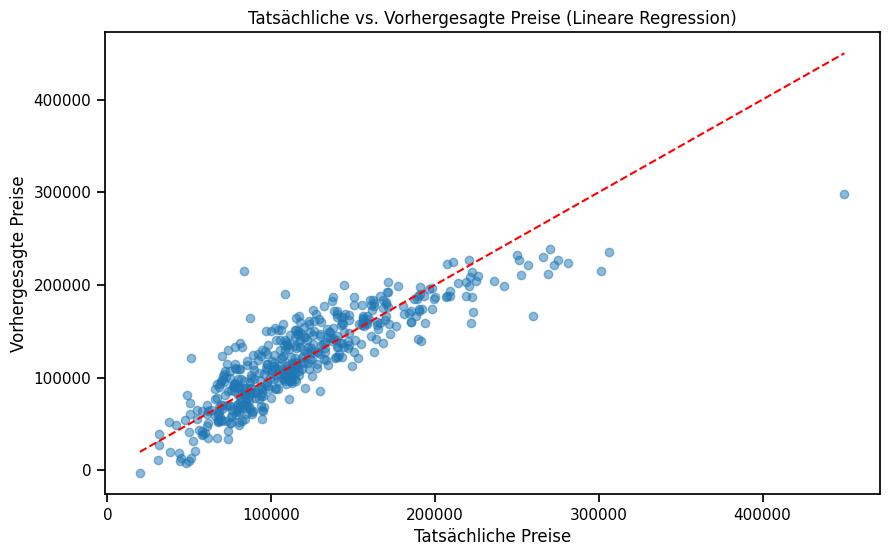

In [109]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_valid)

# Evaluierung der Vorhersagen (R² und MAE)
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# Visualisierung der tatsächlichen vs. vorhergesagten Preise
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Lineare Regression)')
plt.show()

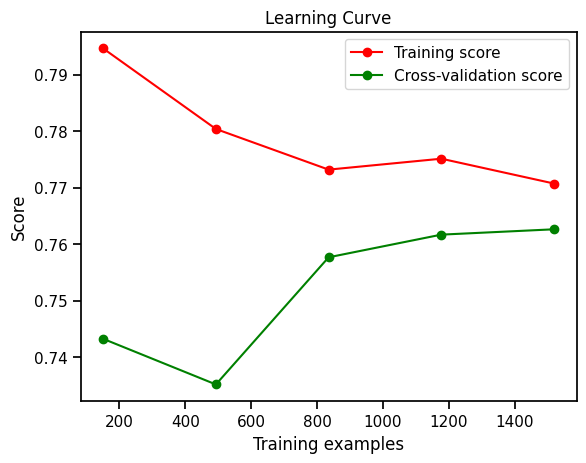

In [110]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(lin_reg, x_train, y_train, cv=5)

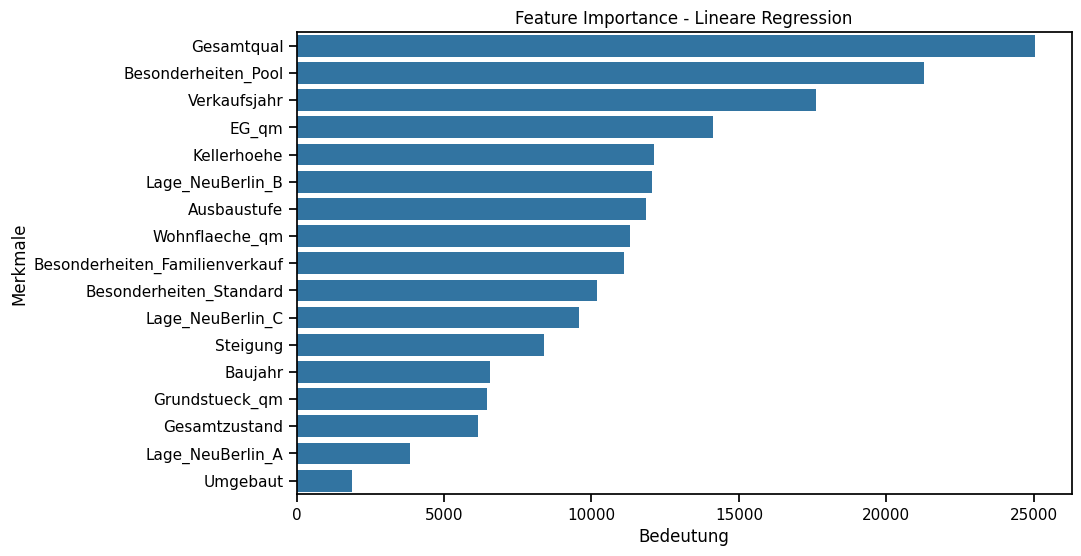

In [111]:
# Feature Importance für lineare Regression
feature_importance_lr = pd.Series(np.abs(lin_reg.coef_), index=x_train.columns)
feature_importance_lr = feature_importance_lr.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_lr.values, y=feature_importance_lr.index)
plt.title('Feature Importance - Lineare Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Die lineare Regression zeigt eine moderate Leistung bei der Vorhersage des Verkaufspreises. Der Mean Absolute Error (MAE) liegt bei etwa 19253 Euro, was darauf hinweist, dass die durchschnittliche Abweichung der Vorhersagen vom tatsächlichen Verkaufspreis relativ hoch ist. Der R²-Wert von 0.7519 deutet darauf hin, dass 75.19% der Varianz im Verkaufspreis durch die verwendeten Merkmale erklärt werden können. Allerdings zeigt das Modell auch Anzeichen von Underfitting, was darauf hindeutet, dass komplexere Modelle möglicherweise bessere Ergebnisse liefern könnten. Das Modell gewichtet insbesondere die Merkmale `Gesamtqual`, `Besonderheiten_Pool`, `Verkaufsjahr` und `EG_qm` als besonders wichtig für die Vorhersage des Verkaufspreises.

### 4.2.2 Entscheidungsbaumregression
Hier wird ein Entscheidungsbaumregressor trainiert und evaluiert.

In [112]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5)
dt_reg.fit(x_train, y_train)
y_pred_dt = dt_reg.predict(x_valid)

Mean Absolute Error (MAE) - Entscheidungsbaum: 18401.54033061085
R² Score - Entscheidungsbaum: 0.7300070280823631


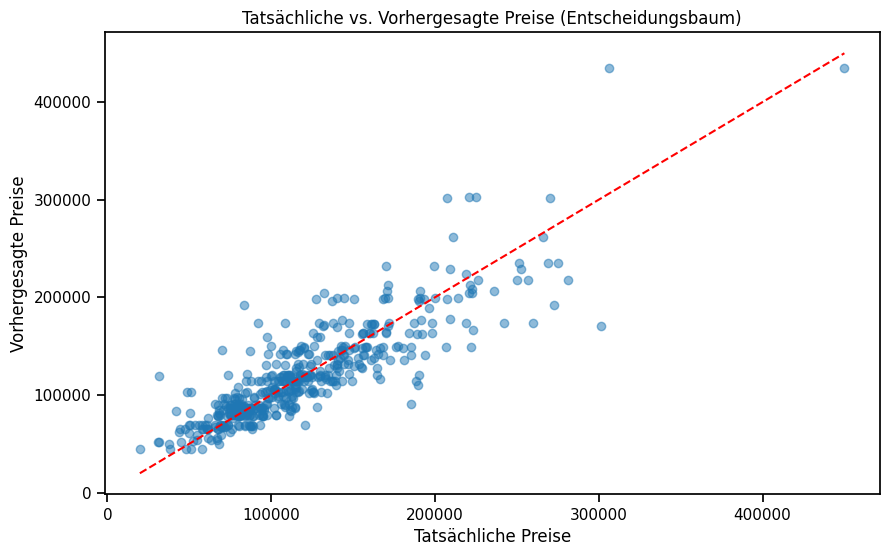

In [113]:
# Evaluierung der Vorhersagen des Entscheidungsbaumregressors
mae_dt = mean_absolute_error(y_valid, y_pred_dt)
r2_dt = r2_score(y_valid, y_pred_dt)

print(f'Mean Absolute Error (MAE) - Entscheidungsbaum: {mae_dt}')
print(f'R² Score - Entscheidungsbaum: {r2_dt}')

# Visualisierung der tatsächlichen vs. vorhergesagten Preise für Entscheidungsbaum
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_dt, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Entscheidungsbaum)')
plt.show()

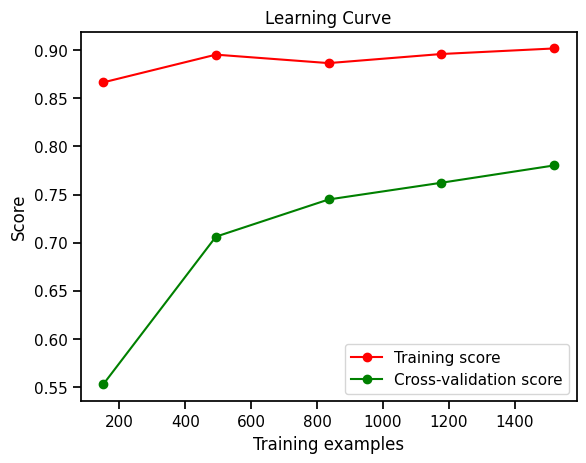

In [114]:
# Untersuchung von Verzerrung und Varianz
plot_learning_curve(dt_reg, x_train, y_train, cv=5)

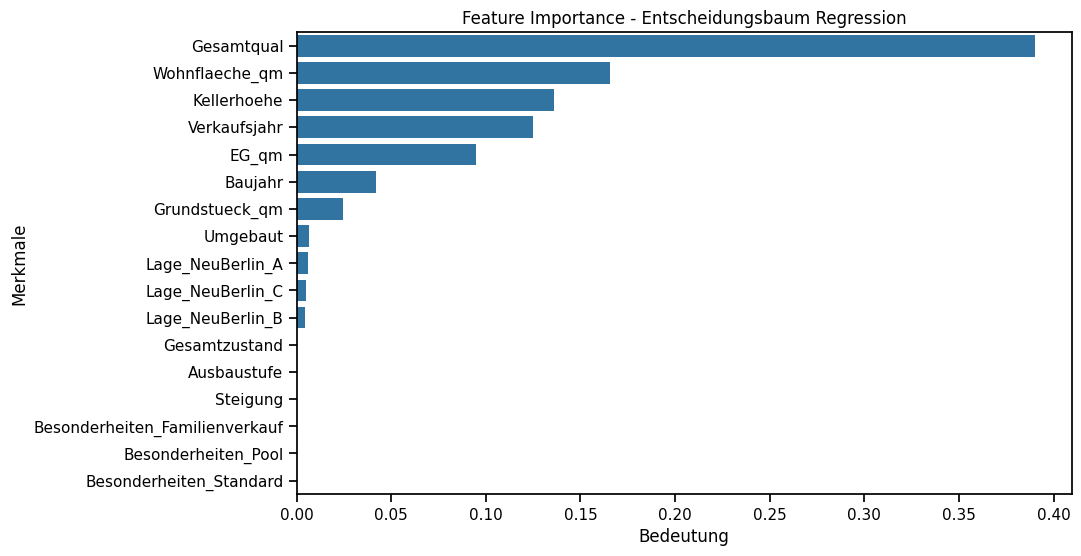

In [115]:
# Feature Importance für Entscheidungsbaum Regression
feature_importance_dt = pd.Series(dt_reg.feature_importances_, index=x_train.columns)
feature_importance_dt = feature_importance_dt.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_dt.values, y=feature_importance_dt.index)
plt.title('Feature Importance - Entscheidungsbaum Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Der Entscheidungsbaumregressor zeigt eine leicht verbesserte Leistung im Vergleich zur linearen Regression. Mit einem Mean Absolute Error (MAE) von etwa 18401 Euro und einem etwas geringeren R²-Wert von 0.73 kann das Modell den Verkaufspreis etwas genauer vorhersagen. Dies deutet darauf hin, dass der Entscheidungsbaum in der Lage ist, komplexere Zusammenhänge in den Daten zu erfassen. Allerdings besteht die Gefahr des Overfittings, insbesondere wenn der Baum zu tief wächst, daher wurde die maximale Tiefe des Baums auf 8 begrenzt sowie die Mindestanzahl der Samples für einen Split auf 10 und die Mindestanzahl der Samples für ein Blatt auf 5 gesetzt. Die Feature-Importance-Analyse zeigt, dass Merkmale wie `Gesamtqual`, `Verkaufsjahr` und `EG_qm` weiterhin eine bedeutende Rolle spielen, jedoch auch die Merkmale `Kellerhoehe` und `Wohnflaeche_qm` an Bedeutung gewonnen haben und zum Teil nun sogar eine höhere Bedeutung haben als die zuvor genannten Merkmale. Im Gegensatz zur linearen Regression gewichtet der Entscheidungsbaum andere Merkmale viel schwächer.

### 4.2.3 Random Forest Regression
Hier wird ein Random Forest Regressor trainiert und evaluiert.

In [116]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15)
rf_reg.fit(x_train, y_train)
y_pred_rf = rf_reg.predict(x_valid)

In [117]:
# Evaluierung der Vorhersagen des Random Forest Regressors
mae_rf = mean_absolute_error(y_valid, y_pred_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

print(f'Mean Absolute Error (MAE) - Random Forest: {mae_rf}')
print(f'R² Score - Random Forest: {r2_rf}')

Mean Absolute Error (MAE) - Random Forest: 14248.988422679447
R² Score - Random Forest: 0.8314669070966044


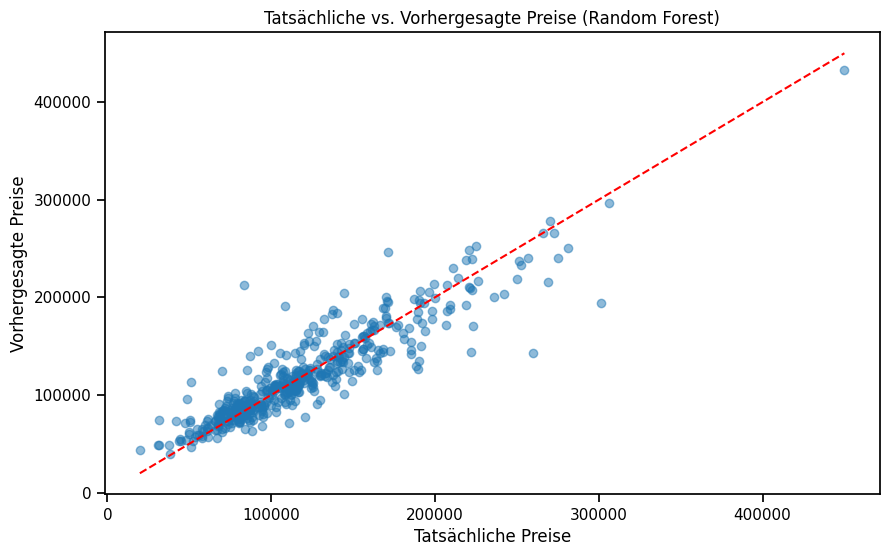

In [118]:
# Visualisierung der tatsächlichen vs. vorhergesagten Preise für Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_rf, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Random Forest)')
plt.show()

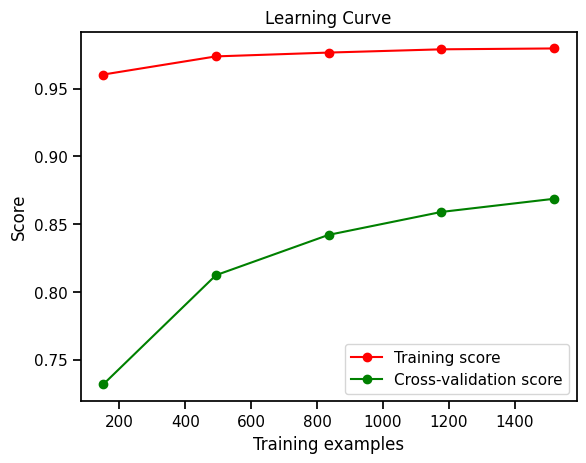

In [119]:
# Untersuchung von Verzerrung und Varianz
plot_learning_curve(rf_reg, x_train, y_train, cv=5)

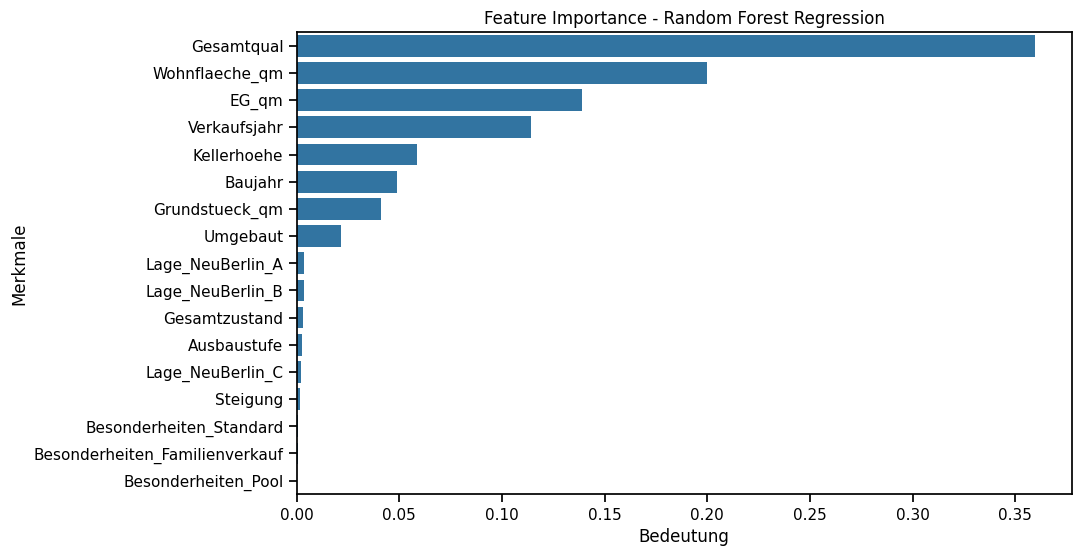

In [120]:
# Feature Importance für Random Forest Regression
feature_importance_rf = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feature_importance_rf = feature_importance_rf.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_rf.values, y=feature_importance_rf.index)
plt.title('Feature Importance - Random Forest Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Der Random Forest Regressor zeigt eine deutliche Verbesserung der Vorhersagegenauigkeit im Vergleich zu den vorherigen Modellen. Mit einem Mean Absolute Error (MAE) von etwa 14248 Euro und einem R²-Wert von 0.8315 kann das Modell den Verkaufspreis wesentlich genauer vorhersagen. Dies deutet darauf hin, dass der Random Forest in der Lage ist, komplexe Zusammenhänge in den Daten zu erfassen und gleichzeitig die Gefahr des Overfittings durch die Aggregation mehrerer Entscheidungsbäume zu minimieren. Die Feature-Importance-Analyse zeigt, dass Merkmale wie `Gesamtqual`, `Wohnflaeche_qm`, `EG_qm` und `Verkaufsjahr` weiterhin eine bedeutende Rolle spielen. Insgesamt zeigt der Random Forest Regressor die beste Leistung unter den getesteten Modellen und ist somit die bevorzugte Wahl für die Vorhersage des Immobilienverkaufspreises in diesem Datensatz.

## 4.3 Vorhersage auf dem Testset
Hier werden die finalen Vorhersagen auf dem zurückgehaltenen Testset durchgeführt.

In [121]:
y_pred_rf_test = rf_reg.predict(data_test)

print("Vorhersagen auf dem Testset abgeschlossen.")
print(f'Vorhersagen auf dem Testset:\n{y_pred_rf_test}')

Vorhersagen auf dem Testset abgeschlossen.
Vorhersagen auf dem Testset:
[101278.61891667 125213.33133333  87818.3114565   76207.34458744
  89280.58620399 127036.92833043  70363.70744048  53057.01775
 109378.0550437   91787.095       75373.01440171  75976.5412097
 149240.12013889 107873.64943816 110463.63309524 103668.04518803
 193844.485      216801.01333333 144111.16053922 106459.97137099
  75370.84620238  84881.40933333 194639.79043103  76148.87325893
  59552.37757143  73571.48110753  80162.50343573 124594.08959779
  84565.3741869   97899.62371429 109251.99075728 143209.52212772
  55197.512      178608.25097222  61819.71748413 113374.02865274
  79521.90481004 208684.365       96490.10776158 129729.71720758
 108460.04788869  82568.08928945 208499.8        128364.59606408
 153032.74595913  87529.03140476 122173.02696815  77318.07623499
  92167.48583333  87232.62431683  87642.902      140493.34872222
 107388.32531349  82246.16250974 285114.04833333  82561.17522615
 178595.40166667  8004

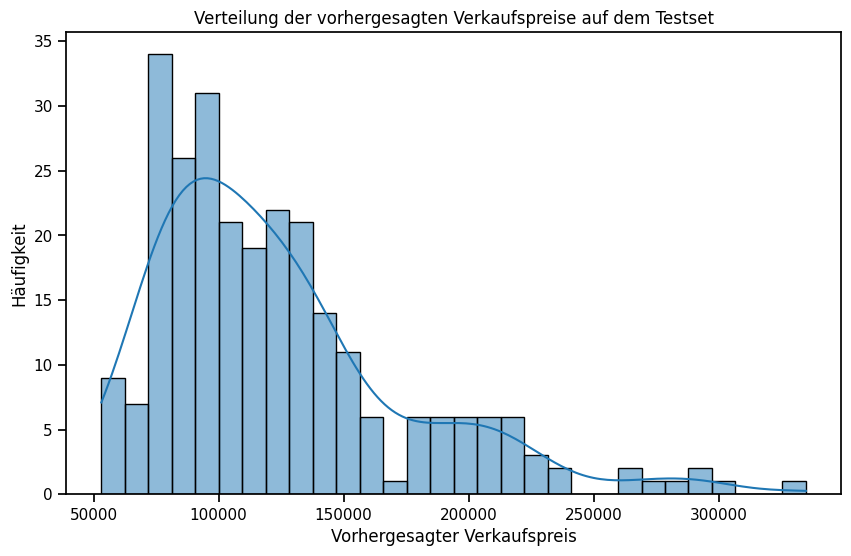

In [122]:
# Visualisierung der Verteilung der vorhergesagten Preise
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_rf_test, bins=30, kde=True)
plt.title('Verteilung der vorhergesagten Verkaufspreise auf dem Testset')
plt.xlabel('Vorhergesagter Verkaufspreis')
plt.ylabel('Häufigkeit')
plt.show()

In [123]:
# Speichern der Vorhersagen in der CSV-Datei data_for_test_filled.csv
data_test_filled = pd.read_csv('data_for_test.csv', sep=';')
data_test_filled['Z_Verkaufspreis'] = y_pred_rf_test.astype(int)
data_test_filled.to_csv('data_for_test_filled.csv', sep=';', index=False)
print("Vorhersagen wurden in 'data_for_test_filled.csv' gespeichert.")


Vorhersagen wurden in 'data_for_test_filled.csv' gespeichert.


# 5. Klassifikation

## 5.1 Vorbereitung der Daten für die Klassifikation

Für die Vorhersage der Lage einer Immobilie wird eine gesonderte Datenvorbereitung durchgeführt, da die Aufgabenstellung eine andere Zielvariable und einen eingeschränkten Merkmalsraum erfordert, im Gegensatz zur vorherigen Analyse.

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Auswahl der Einflussfaktoren (Verkaufspreis und Ausbaustufe)
data_for_classification = data_train[['Z_Verkaufspreis', 'Ausbaustufe']].copy()

# Wiederherstellung der Zielvariable (Lage)
# Da die das Merkmal Lage zuvor One-Hot-Encoded wurde, führen wir diese hier wieder zu einer einzigen Spalte zusammen, die den Namen der Lage enthält
y_dummies = data_train.filter(like='Lage_')
target = y_dummies.idxmax(axis=1)

# Skalierung aus Gründen wie in Kapitel 3.5 genannt
scaler_class = StandardScaler()
data_for_classification_scaled = scaler_class.fit_transform(data_for_classification)

# Datenset Splitten
x_train_cfc, x_test_cfc, y_train_cfc, y_test_cfc = train_test_split(
    data_for_classification_scaled, target, test_size=0.2, random_state=67
)

## 5.2 Modellierung: KNN und Entscheidungsbaum

Für die Klassifikationsaufgabe wurden zwei unterschiedliche Algorithmen verwendet. Als erstes Modell wurde der K-Nearest Neighbors (KNN) Klassifikator gewählt, wobei k=5 gesetzt wurde, sodass die Klassenzuordnung basierend auf den fünf ähnlichsten Nachbarn erfolgt. Ergänzend dazu wurde ein Entscheidungsbaum trainiert. Um Overfitting an die Trainingsdaten zu verhindern, wurde die Tiefe des Baumes auf 5 begrenzt. Beide Modelle wurden anschließend auf den Trainingsdaten gefittet, um Vorhersagen für den Testdatensatz zu generieren.

In [125]:
# Modell A: K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_cfc, y_train_cfc)
y_pred_knn = knn.predict(x_test_cfc)

In [126]:
# Modell B: Entscheidungsbaum
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(x_train_cfc, y_train_cfc)
y_pred_dt = dt.predict(x_test_cfc)

## 5.3 Evaluation und Diskussion der Ergebnisse

In [127]:
print("Allgemein:")
print(f"Genauigkeit Modell 1 (KNN): {accuracy_score(y_test_cfc, y_pred_knn):.2%}")
print(f"Genauigkeit Modell 2 (Decision Tree): {accuracy_score(y_test_cfc, y_pred_dt):.2%}")

print('-' * 40)

print("\nDetail-Analyse (KNN):")
print(classification_report(y_test_cfc, y_pred_knn))

print('-' * 40)

print("\nDetail-Analyse (Entscheidungsbaum):")
print(classification_report(y_test_cfc, y_pred_dt))

Allgemein:
Genauigkeit Modell 1 (KNN): 46.53%
Genauigkeit Modell 2 (Decision Tree): 55.37%
----------------------------------------

Detail-Analyse (KNN):
                  precision    recall  f1-score   support

Lage_NeuBerlin_A       0.35      0.34      0.34       119
Lage_NeuBerlin_B       0.55      0.63      0.59       243
Lage_NeuBerlin_C       0.35      0.25      0.29       113

        accuracy                           0.47       475
       macro avg       0.41      0.40      0.41       475
    weighted avg       0.45      0.47      0.45       475

----------------------------------------

Detail-Analyse (Entscheidungsbaum):
                  precision    recall  f1-score   support

Lage_NeuBerlin_A       0.51      0.36      0.42       119
Lage_NeuBerlin_B       0.60      0.73      0.66       243
Lage_NeuBerlin_C       0.44      0.38      0.41       113

        accuracy                           0.55       475
       macro avg       0.52      0.49      0.50       475
    weig

Die durchgeführte Klassifikation der Wohnlage auf das Testdatenset liefert folgende Genauigkeitswerte (Accuracy):
- KNN: 46.53%
- Entscheidungsbaum: 55.37%
Obwohl beide Modelle deutlich besser abschneiden als bloßes Raten (bei drei Klassen wäre die Zufallswahrscheinlichkeit bei ca. 33,3 %), ist eine Genauigkeit von rund 55 % für einen produktiven Einsatz nicht ausreichend. Die Detailanalyse der Classification-Reports offenbart die Gründe für dieses Ergebnis.

Einerseits erkennt das Modell die Klasse Lage_NeuBerlin_B verhältnismäßig gut (Recall: 0,73 bei Entscheidungsbaum, 0,63 bei KNN). Dies liegt daran, dass dies die häufigste Klasse ist (Support: 243) und sie wie in Kapitel 2 erkennbar das preisliche Mittelfeld abbildet. Das Modell lernt somit, dass es im Zweifel mit `Lage_NeuBerlin_B` am häufigsten richtig liegt.

Andererseits stellt sich ein Problem durch die mangelnde Trennschärfe bei den Rändern von A und C dar. A (Recall: 0,36 bei Entscheidungsbaum, 0,34 bei KNN) und C (Recall: 0,38 bei Entscheidungsbaum und 0,25 bei KNN) werden sehr schlecht erkannt. Das Modell übersieht also fast zwei Drittel der besten und schlechtesten Lagen. Ein höherer Preis kann entweder durch eine gute Lage (A) oder z.B. durch ein sehr großes Haus in einer mittleren Lage (B) entstehen. Ferner kann ein geringerer Preis durch eine schlechte Lage (C), oder durch ein kleineres Haus in mittlerer Lage (B) bedingt sein.

Letztens korreliert das zweite Merkmal `Ausbaustufe` kaum mit der geographischen Lage. Dies zeigt die folgende Feature-Importance der des Entscheidungsbaums anschaulich.

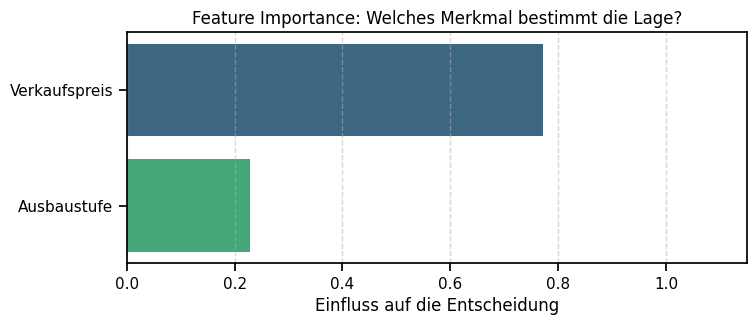

In [128]:
importances = dt.feature_importances_
features = ['Verkaufspreis', 'Ausbaustufe'] 
feature_df = pd.DataFrame({'Merkmal': features, 'Wichtigkeit': importances})
feature_df = feature_df.sort_values(by='Wichtigkeit', ascending=False)

plt.figure(figsize=(8, 3))

ax = sns.barplot(x='Wichtigkeit', y='Merkmal', data=feature_df, palette='viridis')

plt.title('Feature Importance: Welches Merkmal bestimmt die Lage?')
plt.xlabel('Einfluss auf die Entscheidung')
plt.ylabel('')
plt.xlim(0, 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

## 5.4 Fazit
Das Experiment belegt, dass der Kaufpreis und die Anzahl der Stockwerke allein ungeeignete Merkmale für die Lagebestimmung sind. Für eine zufriedenstellende Klassifikation wäre zumindest die Wohnfläche, beispielsweise zur Berechnung des Quadratmeterpreises, erforderlich.

# 6. Clustering der Immobilien

In diesem Abschnitt wird Clustering verwendet, um Immobilien basierend auf ihren Merkmalen zu gruppieren (ausgenommen dem Merkmal `Bezirk`). Ziel ist es, ähnliche Immobilien zu identifizieren, die möglicherweise ähnliche Preisstrukturen oder Investitionspotenziale aufweisen.

## 6.1 Vorbereitung der Daten für das Clustering

Für das Clustering der Immobilien wird eine gesonderte Datenvorbereitung durchgeführt, da die Aufgabenstellung einen eingeschränkten Merkmalsraum erfordert.

In [129]:
# Entfernen der Dummy-Variablen für Lage
dummy_cols = data_train.filter(like='Lage_').columns
districts = y_dummies.idxmax(axis=1)
data_for_clustering = data_train.copy().drop(columns=dummy_cols)
data_for_clustering.head()

Ausbaustufe   Baujahr     EG_qm  Gesamtqual  Gesamtzustand  Grundstueck_qm  \
0          1.0 -0.364652  1.620925           2              2        0.990605   
1          1.0  0.374775  1.319800           2              2        2.020135   
2          1.0 -1.558284 -0.539905           1              1        0.271916   
3          1.0 -0.094814 -0.150523           2              2        0.820853   
4          1.0  0.274428  0.916519           3              3        0.420761   

   Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  \
0            2         1 -1.224508     -0.049321        0.763730   
1            3         2 -0.148821     -1.213078        0.471898   
2            1         3 -1.569304      0.725553       -1.330411   
3            2         1 -0.831959     -1.213078       -0.953046   
4            3         1  1.059159     -0.824966        0.081064   

   Z_Verkaufspreis  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
0           100088                           False                False   
1           145148                           False                False   
2            48860                           False                False   
3            72349                           False                False   
4           138313                           False                False   

   Besonderheiten_Standard  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True

## 6.2 Anwendung von K-Means Clustering
Hier wird das K-Means Clustering auf die vorbereiteten Daten angewendet, um Gruppen ähnlicher Immobilien zu identifizieren. Als Anzahl der Cluster werden 3 gewählt, da bereits bekannt ist, dass es drei Bezirke gibt.

In [130]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_for_clustering)
clusters = kmeans.labels_
data_for_clustering['Cluster'] = clusters
data_for_clustering['Bezirk'] = districts
data_for_clustering.head()

Ausbaustufe   Baujahr     EG_qm  Gesamtqual  Gesamtzustand  Grundstueck_qm  \
0          1.0 -0.364652  1.620925           2              2        0.990605   
1          1.0  0.374775  1.319800           2              2        2.020135   
2          1.0 -1.558284 -0.539905           1              1        0.271916   
3          1.0 -0.094814 -0.150523           2              2        0.820853   
4          1.0  0.274428  0.916519           3              3        0.420761   

   Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  \
0            2         1 -1.224508     -0.049321        0.763730   
1            3         2 -0.148821     -1.213078        0.471898   
2            1         3 -1.569304      0.725553       -1.330411   
3            2         1 -0.831959     -1.213078       -0.953046   
4            3         1  1.059159     -0.824966        0.081064   

   Z_Verkaufspreis  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
0           100088                           False                False   
1           145148                           False                False   
2            48860                           False                False   
3            72349                           False                False   
4           138313                           False                False   

   Besonderheiten_Standard  Cluster            Bezirk  
0                     True        0  Lage_NeuBerlin_B  
1                     True        2  Lage_NeuBerlin_B  
2                     True        0  Lage_NeuBerlin_A  
3                     True        0  Lage_NeuBerlin_C  
4                     True        2  Lage_NeuBerlin_C

## 6.3 Analyse der Cluster-Ergebnisse
Im folgenden werden die Ergebnisse des K-Means Clustering analysiert, um Einblicke in die identifizierten Gruppen ähnlicher Immobilien zu gewinnen.

### 6.3.1 Rückskalierung und Rücktransformation der Merkmale
Um die Cluster-Ergebnisse besser interpretieren zu können, werden die skalierten Merkmale zurücktransformiert und in ihre ursprünglichen Einheiten zurückskaliert. Dies ermöglicht eine anschaulichere Darstellung der Cluster in Bezug auf die ursprünglichen Merkmale der Immobilien.

In [131]:
# Rückskalierung der Merkmale für bessere Interpretierbarkeit
cols_to_inverse = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Verkaufsjahr', 'Umgebaut']
data_for_clustering[cols_to_inverse] = scaler.inverse_transform(
    data_for_clustering[cols_to_inverse]
)

# Rücktransformation der logarithmierten Merkmale
data_for_clustering['Baujahr'] = np.expm1(data_for_clustering['Baujahr'])
data_for_clustering['EG_qm'] = np.expm1(data_for_clustering['EG_qm'])
data_for_clustering['Wohnflaeche_qm'] = np.expm1(data_for_clustering['Wohnflaeche_qm'])
data_for_clustering['Grundstueck_qm'] = np.expm1(data_for_clustering['Grundstueck_qm'])
data_for_clustering['Umgebaut'] = np.expm1(data_for_clustering['Umgebaut'])
data_for_clustering['Verkaufsjahr'] = np.expm1(data_for_clustering['Verkaufsjahr'])

data_for_clustering.head()

Ausbaustufe  Baujahr  EG_qm  Gesamtqual  Gesamtzustand  Grundstueck_qm  \
0          1.0   1960.0  166.0           2              2          1428.0   
1          1.0   1982.0  151.0           2              2          2365.0   
2          1.0   1925.0   84.0           1              1          1004.0   
3          1.0   1968.0   95.0           2              2          1314.0   
4          1.0   1979.0  133.0           3              3          1080.0   

   Kellerhoehe  Steigung  Umgebaut  Verkaufsjahr  Wohnflaeche_qm  \
0            2         1    1960.0        2009.0           166.0   
1            3         2    1982.0        2006.0           151.0   
2            1         3    1953.0        2011.0            84.0   
3            2         1    1968.0        2006.0            95.0   
4            3         1    2007.0        2007.0           133.0   

   Z_Verkaufspreis  Besonderheiten_Familienverkauf  Besonderheiten_Pool  \
0           100088                           False                False   
1           145148                           False                False   
2            48860                           False                False   
3            72349                           False                False   
4           138313                           False                False   

   Besonderheiten_Standard  Cluster            Bezirk  
0                     True        0  Lage_NeuBerlin_B  
1                     True        2  Lage_NeuBerlin_B  
2                     True        0  Lage_NeuBerlin_A  
3                     True        0  Lage_NeuBerlin_C  
4                     True        2  Lage_NeuBerlin_C

### 6.3.2 Datenexploration mit Bezug auf die Bezirke
Es wird eine neue Scatterplot-Matrix erstellt, die die Bezirke mit allen sinnvollen Kombinationen der Merkmale zeigt, um nach den geeignetesten Darstellungen zu suchen, welche die Bezirke am besten trennen.

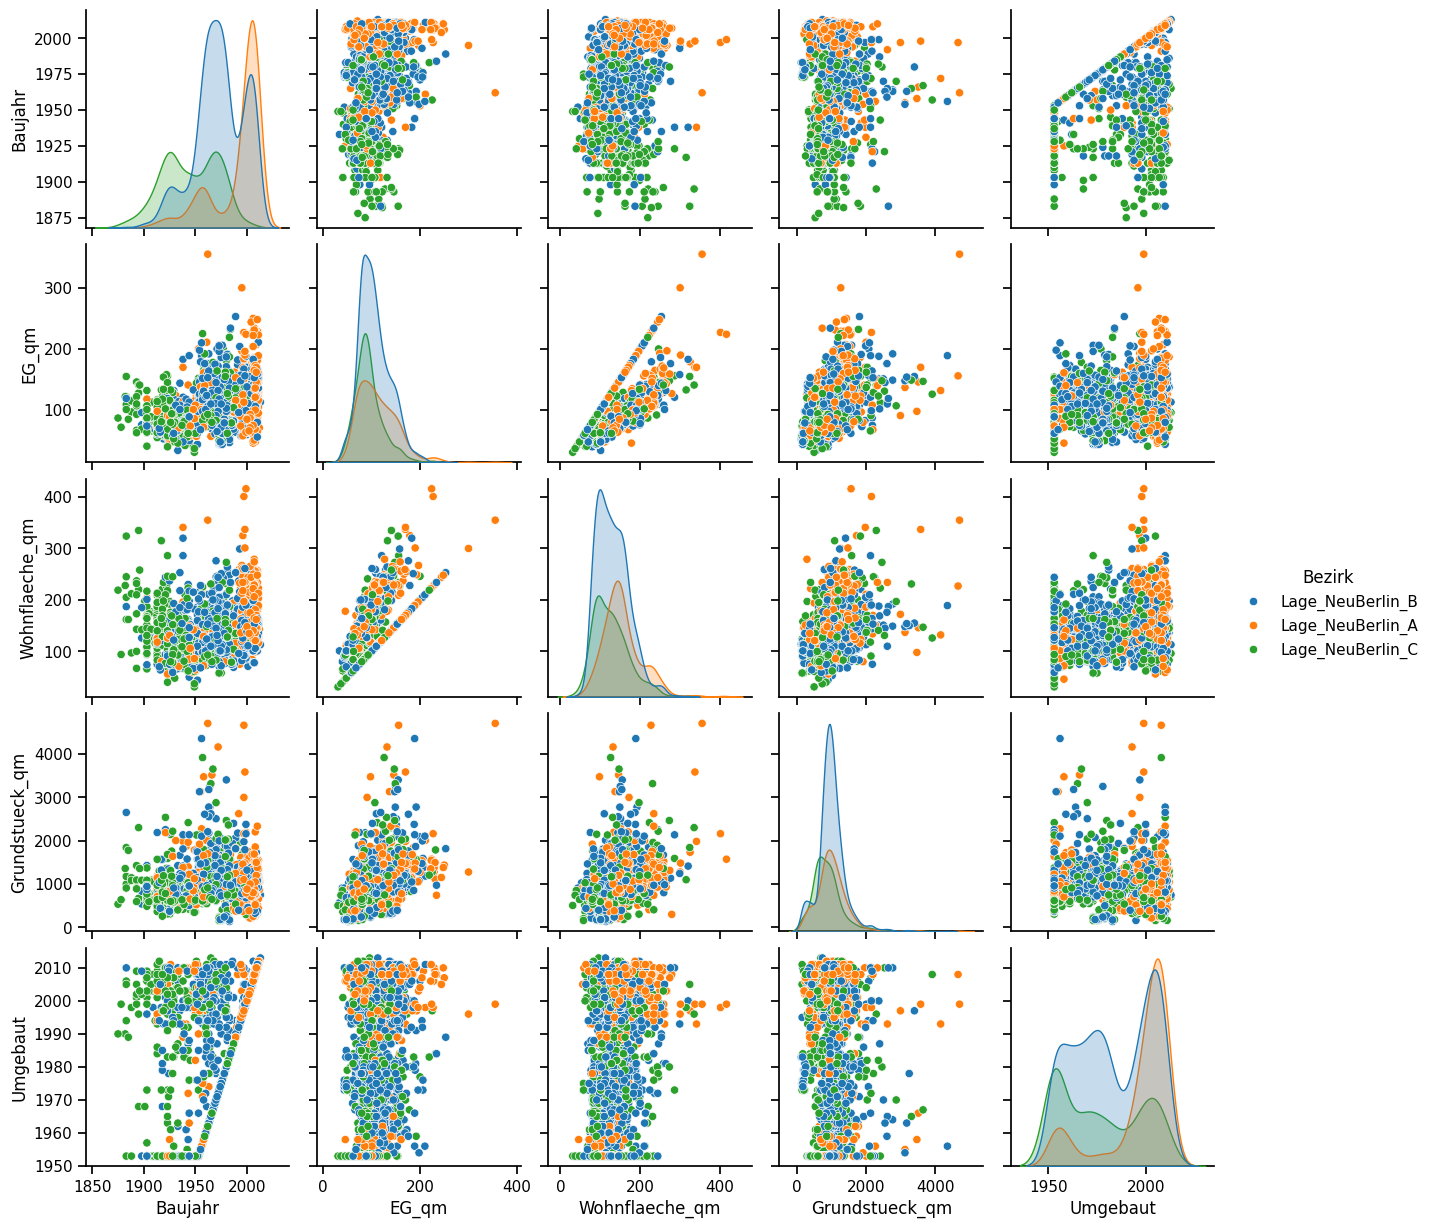

In [132]:
# Matrix die die Bezirke mit allen Kombinationen der Markmale zeigt
columns_to_plot = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Umgebaut', 'Bezirk']
scatterplot = sns.pairplot(data_for_clustering[columns_to_plot], hue='Bezirk')
scatterplot

Visuell lässt sich erkennen, dass es schwierig ist, die Bezirke nur anhand von zwei Merkmalen klar zu trennen, am Besten ist dies jedoch bei der Kombination aus `Wohnflaeche_qm` und `Baujahr` möglich. Im Folge wird diese Kombination genauer betrachtet um die Cluster und die tatsächlichen Bezirke zu vergleichen.

### 6.3.3 Datenexploration mit Bezug auf die Cluster
Es wird eine neue Scatterplot-Matrix erstellt, die die Cluster mit allen sinnvollen Kombinationen der Merkmale zeigt, um nach den geeignetesten Darstellungen zu suchen, welche die Cluster am besten trennen.

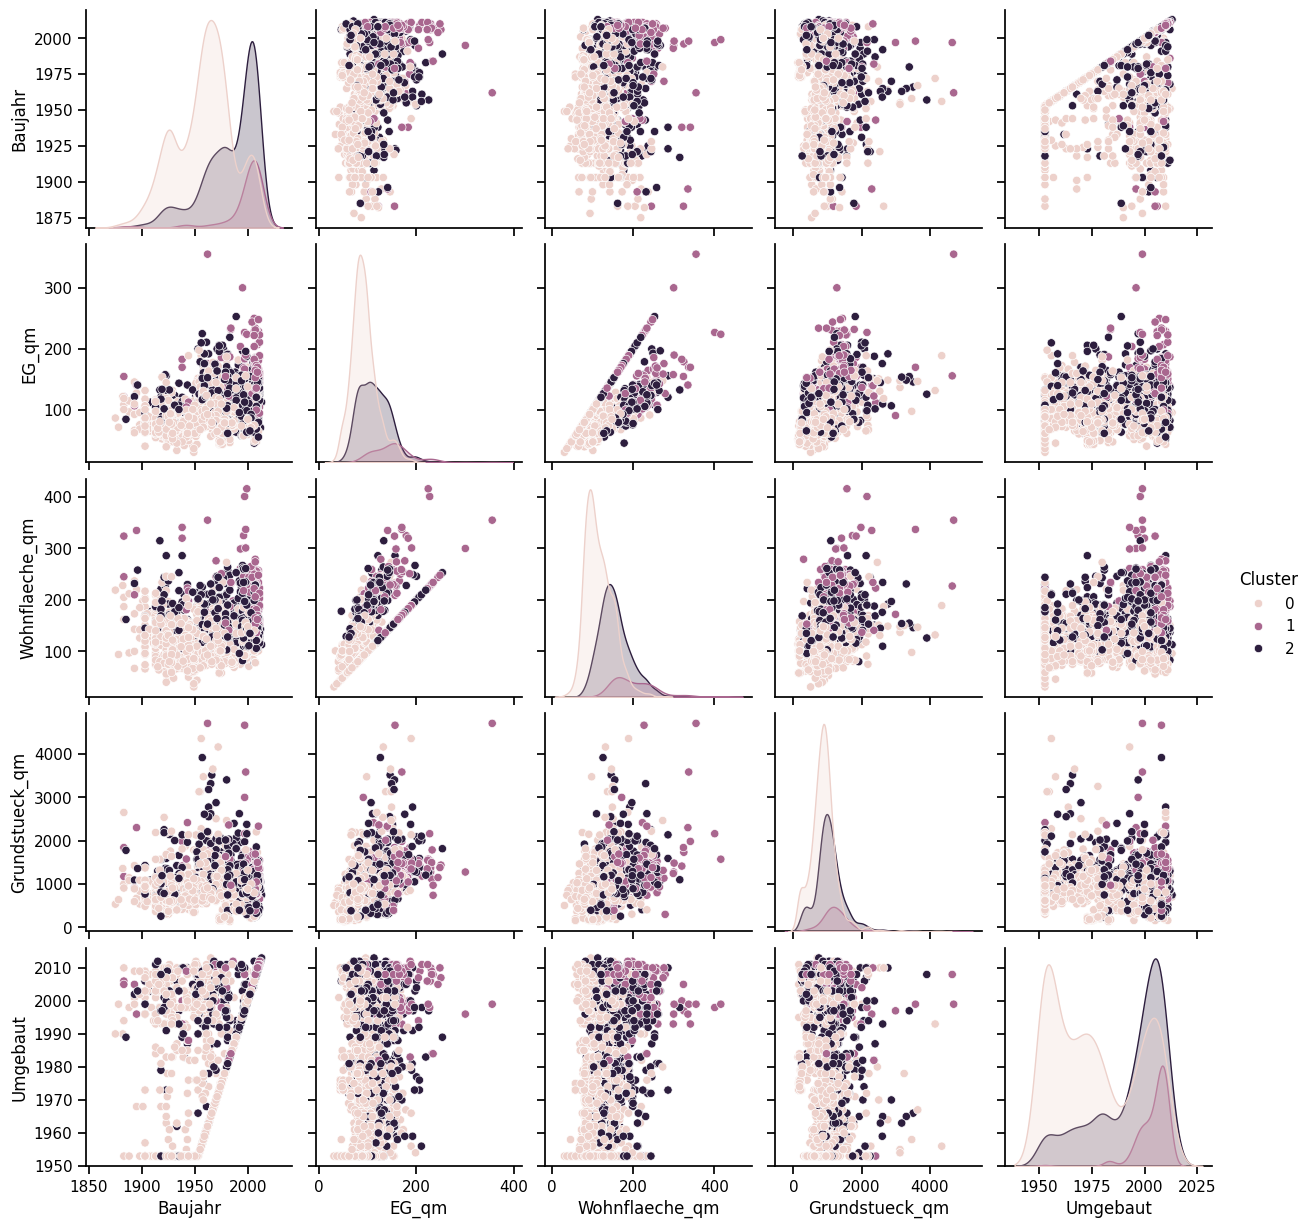

In [133]:
# Matrix die die Cluster mit allen Kombinationen der Markmale zeigt
columns_to_plot = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Umgebaut', 'Cluster']
scatterplot = sns.pairplot(data_for_clustering[columns_to_plot], hue='Cluster')
scatterplot

Die Scatterplot-Matrix zeigt, dass die Cluster sich nicht gut trennen lassen auf den meisten dargestellten Kombinationen der Merkmale. Dies deutet darauf hin, dass die gewählten Merkmale möglicherweise nicht ausreichend sind, um klare Gruppen zu bilden, oder dass die Cluster in einem höherdimensionalen Raum besser trennbar sind. Am besten lassen sich die Cluster, wie bei den Bezirken, mit der Kombination aus `Wohnflaeche_qm` und `Baujahr` trennen.

### 6.3.4 Vergleich der Cluster mit den Bezirken mit Bezug auf Wohnfläche und Baujahr
Hier wird die Kombination aus `Wohnflaeche_qm` und `Baujahr` genauer betrachtet, um die Cluster und die tatsächlichen Bezirke zu vergleichen.

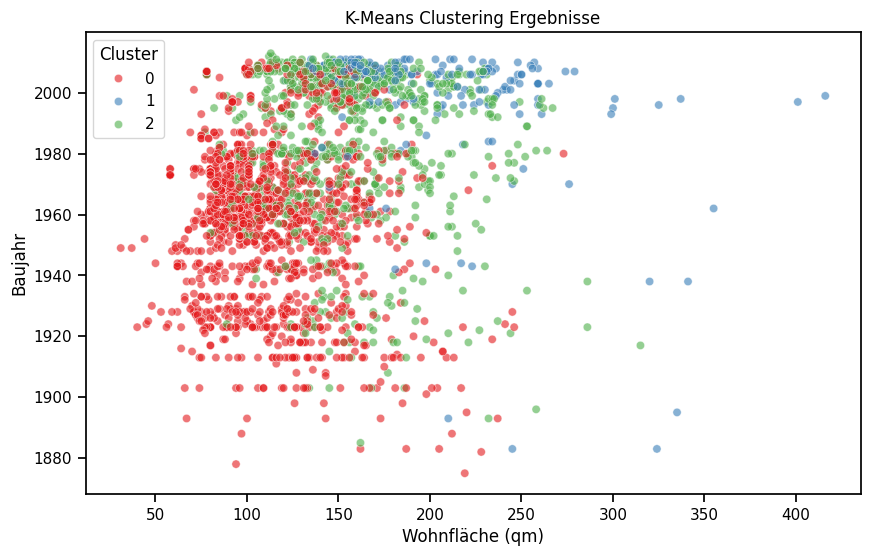

In [134]:
# Geeignete Visualisierung der Cluster-Ergebnisse
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Wohnflaeche_qm', 
    y='Baujahr', 
    hue='Cluster', 
    palette='Set1', 
    data=data_for_clustering, 
    alpha=0.6
)
plt.title('K-Means Clustering Ergebnisse')
plt.xlabel('Wohnfläche (qm)')
plt.ylabel('Baujahr')
plt.legend(title='Cluster')
plt.show()

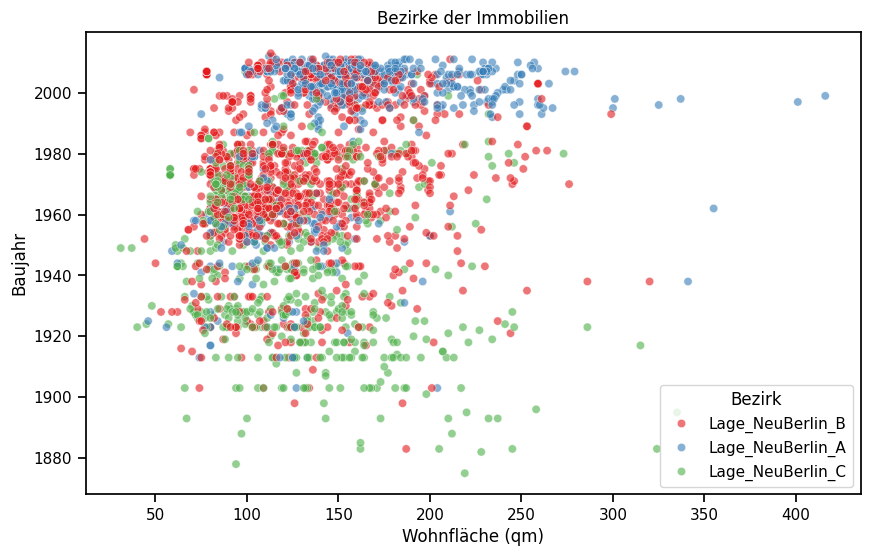

In [135]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Wohnflaeche_qm', 
    y='Baujahr', 
    hue='Bezirk', 
    palette='Set1', 
    data=data_for_clustering, 
    alpha=0.6
)
plt.title('Bezirke der Immobilien')
plt.xlabel('Wohnfläche (qm)')
plt.ylabel('Baujahr')
plt.legend(title='Bezirk')
plt.show()

Visuell lässt sich erkennen, dass der Bezirk NeuBerlin_A teilweise mit dem Cluster 1 übereinstimmt, während NeuBerlin_C und NeuBerlin_B größtenteils den Clustern 0 und 2 zugeordnet werden, jedoch ohne klare Trennung, sodass sich die Cluster nicht eindeutig den Bezirken zuordnen lassen. 

### 6.3.5 Korrelation der Cluster mit den Bezirken
Hier wird untersucht, ob die gebildeten Cluster mit den zurückgehalten Bezirken korrelieren.

In [136]:
# Korrelation zwischen den Clustern und den Bezirken analysieren
contingency_table = pd.crosstab(data_for_clustering['Cluster'], data_for_clustering['Bezirk'])
print("Kontingenztabelle zwischen Clustern und Bezirken:")
print(contingency_table)

Kontingenztabelle zwischen Clustern und Bezirken:
Bezirk   Lage_NeuBerlin_A  Lage_NeuBerlin_B  Lage_NeuBerlin_C
Cluster                                                      
0                     216               669               457
1                     137                47                14
2                     266               458               110


Wie bereits in Kapitel 6.3.4 am Beispiel der Kombination aus `Wohnflaeche_qm` und `Baujahr` gezeigt, lässt sich das Cluster 1 mit höchster Wahrscheinlichkeit dem Bezirk NeuBerlin_A zuordnen, jedoch nicht eineindeutig, da nur etwa 22% der Immobilien im Bezirk NeuBerlin_A sich im Cluster 1 befinden. Die Cluster 0 und 2 hingegen zeigen keine klare Korrelation mit den Bezirken NeuBerlin_B und NeuBerlin_C, da diese Cluster Immobilien aus beiden Bezirken enthalten. Dies deutet darauf hin, dass die gewählten Merkmale für das Clustering nicht ausreichend sind, um die Bezirke klar zu trennen.

# 7. Deployment
In diesem abschließenden Kapitel werden die zu Beginn definierten Projektziele mit den tatsächlichen Ergebnissen der Modellierung und Analyse abgeglichen.

### 7.1 Evaluation Ziel 1: Identifikation von unterbewerteten Immobilien
Das Ziel war die präzise Vorhersage eines fairen Marktpreises, um Immobilien zu identifizieren, deren Angebotspreis signifikant unter der Modellvorhersage liegt.

**Ergebnis:**
Das entwickelte Regressionsmodell (Kapitel 4) konnte die Zusammenhänge zwischen den Merkmalen und dem Kaufpreis abbilden. Die folgende Abbildung zeigt wie der Random Forest Regressor erfolgreich die Preise vorhersagt.

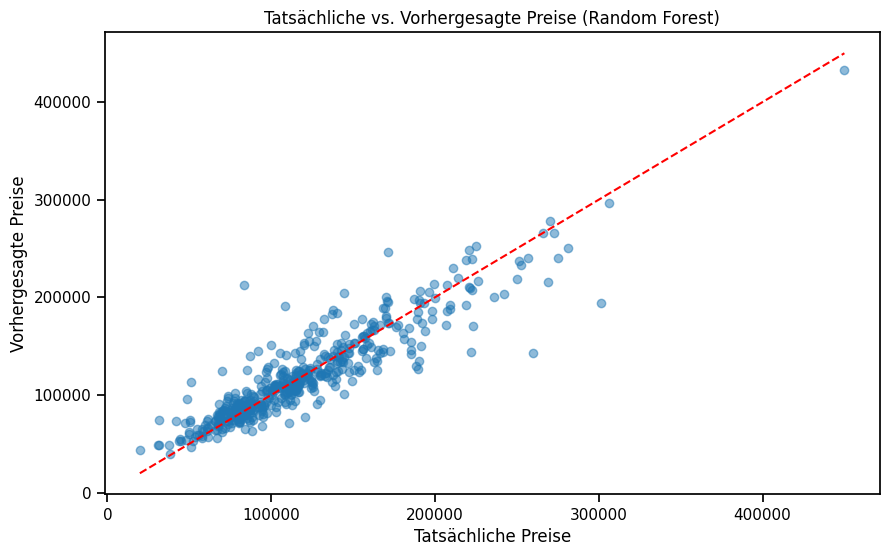

In [137]:

# Visualisierung der tatsächlichen vs. vorhergesagten Preise für Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_rf, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Random Forest)')
plt.show()


**Fazit:** Das Ziel wurde erreicht. Das Modell liefert eine quantifizierbare Entscheidungsgrundlage für den potenziellen Ankauf.


### 7.2 Evaluation zu Ziel 2: Prädiktion der Bezirkszugehörigkeit

**Zielsetzung:**
Es sollte geprüft werden, ob sich die Lage (Bezirk NeuBerlin A, B, C) allein durch physische Merkmale vorhersagen lässt und ob die Bezirke strukturell klar voneinander getrennt sind.

#### 7.2.1 Ergebnis der Klassifikation
Die Anwendung überwachter Lernverfahren zur Vorhersage des Bezirks lieferte folgende Ergebnisse:

Das trainierte K-Nearest-Neighbors Modell erreichte eine Accuracy von 46.53% und das Entscheidungsbaum-Modell eine Accuracy von 55.37%.
Die Analyse zeigte, dass der Bezirk NeuBerlin_B mit generell höherer Präzision vorhergesagt werden konnte. Hingegen traten bei der Unterscheidung zwischen NeuBerlin_A und NeuBerlin_C häufigere Fehlklassifikationen durch die geringe Trennschärfe mit NeuBerlin_B auf.

Die folgende Abbildung stellt die Ergebnisse wie beschrieben dar.
In der Konfusionsmatrix, dass das Modell einen starken Bias zum Mehrheitsbezirk NeuBerlin_B aufweist. Dies wird besonders in der ersten Zeile sichtbar. Für den Bezirk NeuBerlin_A ist das Feld für die Vorhersage B dunkler gefärbt als das Feld für die korrekte Vorhersage A. Das bedeutet, dass tatsächliche Häuser aus Bezirk A häufiger fälschlicherweise Bezirk B zugeordnet wurden, als dass sie korrekt erkannt wurden.

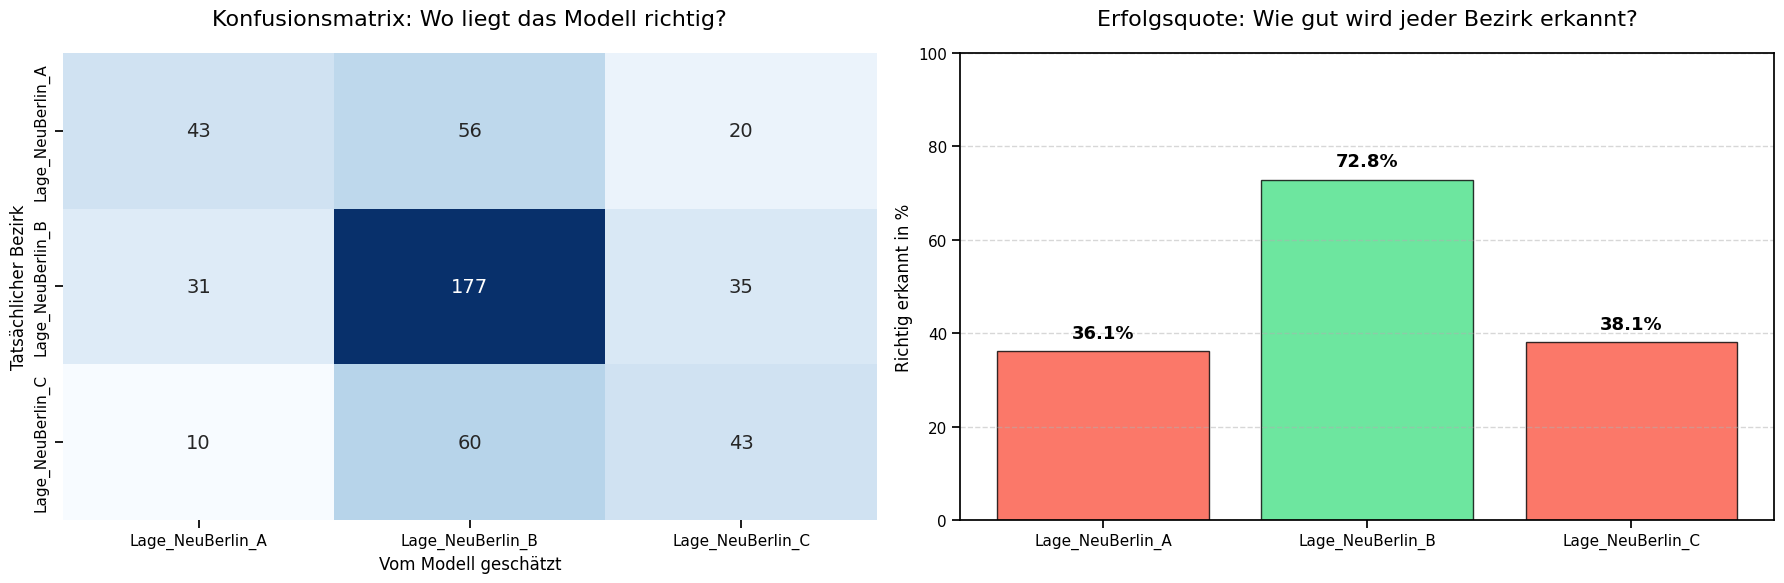

In [138]:
from sklearn.metrics import confusion_matrix

y_true = y_test_cfc
y_pred = y_pred_dt

labels = sorted(list(set(y_true)))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

cm = confusion_matrix(y_true, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[0], annot_kws={"size": 14})
axes[0].set_title('Konfusionsmatrix: Wo liegt das Modell richtig?', fontsize=16, pad=20)
axes[0].set_xlabel('Vom Modell geschätzt', fontsize=12)
axes[0].set_ylabel('Tatsächlicher Bezirk', fontsize=12)

accuracies = cm.diagonal() / cm.sum(axis=1)

# Grün wenn > 70%, sonst Rot
colors = ["#48e087" if x >= 0.7 else "#fa5644" for x in accuracies] 

bars = axes[1].bar(labels, accuracies * 100, color=colors, alpha=0.8, edgecolor='black')

axes[1].set_title('Erfolgsquote: Wie gut wird jeder Bezirk erkannt?', fontsize=16, pad=20)
axes[1].set_ylabel('Richtig erkannt in %', fontsize=12)
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 2,
                 f'{acc:.1%}', ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


**Fazit:** Selbst unter Vorgabe der Zielvariable gelang es dem Modell nicht, die Bezirke B und C fehlerfrei zu trennen, was die Hypothese der starken strukturellen Ähnlichkeit dieser beiden Gebiete stützt.


#### 7.2.2 Ergebnis des Clusterings
Die Untersuchungen mittels Clustering (K-Means) und der Vergleich mit den tatsächlichen Bezirken (Kapitel 6) zeigten folgende Resultate:

Wie die Kontingenztafel und die Cluster-Plots zeigten, gibt es massive Überlappungen zwischen den Bezirken. Zwar korreliert Cluster 1 stark mit NeuBerlin_A, aber Cluster 0 und 2 beinhalten eine Mischung aus den Bezirken B und C. Die Ergebnisse deuten darauf hin, dass die Bausubstanz (Wohnfläche/Baujahr) in den Bezirken B und C zu ähnlich ist, um sie algorithmisch klar zu trennen. Ein typisches Haus in Bezirk B sieht einem Haus in Bezirk C sehr ähnlich.

Die nachfolgende Abbildung visualisiert diese Verteilung. Durch die relative Einfärbung der Heatmap tritt die starke Assoziation von Cluster 1 mit dem Bezirk 'NeuBerlin_A' deutlich hervor, was die oben genannte klare Trennbarkeit bestätigt. Hingegen zeigen Cluster 0 und 2 visuell keine starke eindeutige Zuordnung, sondern verteilen sich über alle Bezirke, wobei Cluster 0 stark von B und C dominiert wird. Das Balkendiagramm zur Cluster-Reinheit unterstreicht dies ebenfalls. Während der Balken für Cluster 1 fast ausschließlich aus Bezirk A besteht, setzen sich Cluster 0 und 2 heterogen zusammen, was die Hypothese der zu ähnlichen Bausubstanz in den Bezirken B und C stützt.

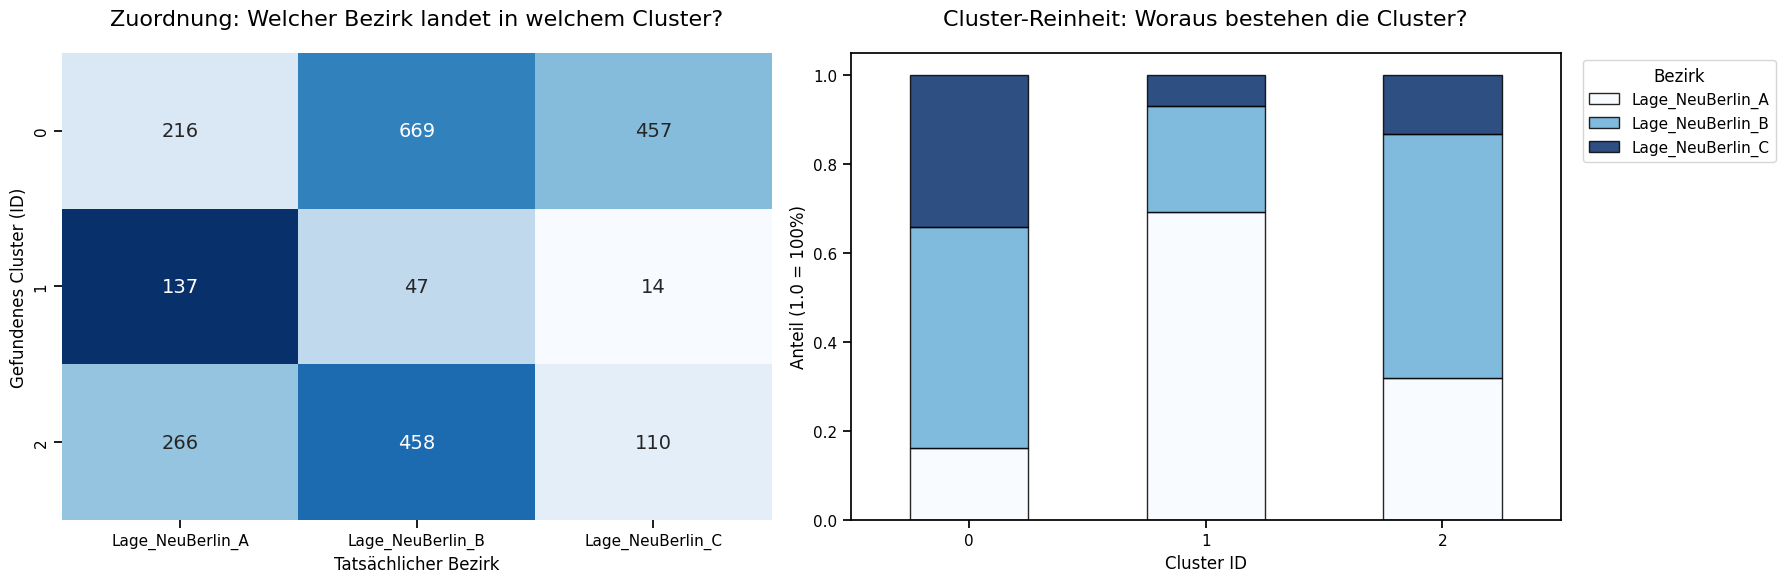

In [139]:
contingency_table = pd.crosstab(data_for_clustering['Cluster'], data_for_clustering['Bezirk'])

ct_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(
    ct_norm,    
    annot=contingency_table,
    fmt='d', 
    cmap='Blues', 
    cbar=False, 
    ax=axes[0], 
    annot_kws={"size": 14}
)
axes[0].set_title('Zuordnung: Welcher Bezirk landet in welchem Cluster?', fontsize=16, pad=20)
axes[0].set_ylabel('Gefundenes Cluster (ID)', fontsize=12)
axes[0].set_xlabel('Tatsächlicher Bezirk', fontsize=12)

ct_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap='Blues', alpha=0.85, edgecolor='black', rot=0)

axes[1].set_title('Cluster-Reinheit: Woraus bestehen die Cluster?', fontsize=16, pad=20)
axes[1].set_ylabel('Anteil (1.0 = 100%)', fontsize=12)
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].legend(title='Bezirk', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Fazit:** Das Ziel wurde teilweise erreicht, jedoch mit einer negativen Erkenntnis. Die physischen Merkmale allein reichen nicht aus, um den Bezirk fehlerfrei vorherzusagen. Für eine präzise Standortbestimmung wären zusätzliche geografische Daten notwendig.

### 7.3 Gesamtfazit

Das Projekt zeigt, dass der Immobilienmarkt von "NeuBerlin" zwar preislich logischen Regeln folgt, erkennbar durch die erfolgreiche Regression, aber strukturell sehr homogen ist. Dies zeigt sich besonders durch die schwierige Klassifikation der Bezirke. Für Investoren bedeutet dies, dass sich der Preis gut validieren lässt. Die Lage ist jedoch nicht allein durch die Objektart ersichtlich.